## To compare different results 

In [164]:
from ast import literal_eval
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
import statistics as stats
import seaborn as sns
import datetime
import json
import numpy as np
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import operator
from utils.io import get_yelp_df, df_to_sparse, filter_yelp_df, date_to_timestamp, get_corpus_idx_list, valid_combinations, setBinary
from utils.matrix import get_I_C, get_rating_timestamp_matrix, get_UC_Matrix, getImplicitMatrix
from utils.timesplit import time_ordered_splitModified
from prediction.models import preprocess, individualKNNPrediction, simpleKNNPrediction, predictUU
from evaluation.metrics import evaluate

## Dataset files 

In [4]:
#reviewJson = "..\\data\\Export_CleanedReview.json"
reviewJsonWithClosedRes = "..\\data\\Export_CleanedReviewWithClosedRes.json"
reviewJsonWithBusAvgStars = "..\\data\\Export_CleanedReviewNew_1011.json"
# with open(reviewJson, encoding = 'utf-8') as json_file:
#     data = json_file.readlines()
#     data = list(map(json.loads, data))

#This appeared to be a neasted list, just use data[0] to read
# df_review = pd.DataFrame(data[0])

## Load Data
Select top frenquent user and top frequenty restaurants that had at least 1 review >= 4 stars (Kickking out users that gave all  reviews <=3 and restaurants that never got start >= 4 stars)

## Get rating-UI and timestamp-UI matrix from original df

#### Get Explicit UC Matrix

## Time ordered split 

## Time Order Split modified for adjusting training dataset size

In [22]:
# "Modified this to take in train sampling"
# "Modified this to add and return original valid set"

# def time_ordered_splitModified(rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, ratio=[0.5, 0.2, 0.3],
#                        implicit=True, remove_empty=False, threshold=3,
#                        sampling=False, sampling_ratio=0.1, trainSampling=1):
#     """
#     Split the data to train,valid,test by time
#     ratio:  train:valid:test
#     threshold: for implicit representation
#     """
#     if implicit:
#         temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
#         temp_rating_matrix[(rating_matrix > threshold).nonzero()] = 1
#         rating_matrix = temp_rating_matrix
#         timestamp_matrix = timestamp_matrix.multiply(rating_matrix)
#         #ratingWuserAvg_matrix = ratingWuserAvg_matrix.multiply(rating_matrix)

#     nonzero_index = None

#     #Default false, not removing empty columns and rows
#     #Should not have this case, since users should have at least 1 record of 4,5 
#     #And restuarant should have at least 1 record of 4,5 
#     if remove_empty:
#         # Remove empty columns. record original item index
#         nonzero_index = np.unique(rating_matrix.nonzero()[1])
#         rating_matrix = rating_matrix[:, nonzero_index]
#         timestamp_matrix = timestamp_matrix[:, nonzero_index]
#         ratingWuserAvg_matrix = ratingWuserAvg_matrix[:, nonzero_index]

#         # Remove empty rows. record original user index
#         nonzero_rows = np.unique(rating_matrix.nonzero()[0])
#         rating_matrix = rating_matrix[nonzero_rows]
#         timestamp_matrix = timestamp_matrix[nonzero_rows]
#         ratingWuserAvg_matrix = ratingWuserAvg_matrix[nonzero_rows]

#     user_num, item_num = rating_matrix.shape

#     rtrain = []
#     rtrain_userAvg = []
#     rtime = []
#     rvalid = []
#     rvalid_userAvg = []
#     rtest = []
#     rtest_userAvg = []
#     # Get the index list corresponding to item for train,valid,test
#     item_idx_train = []
#     item_idx_valid = []
#     item_idx_test = []
    
#     for i in tqdm(range(user_num)):
#         #Get the non_zero indexs, restuarants where the user visited/liked if implicit 
#         item_indexes = rating_matrix[i].nonzero()[1]        
#         #Get the data for the user
#         data = rating_matrix[i].data      
#         #Get time stamp value 
#         timestamp = timestamp_matrix[i].data 
#         #Get review stars with user avg data 
#         if implicit == False:
#             dataWuserAvg = ratingWuserAvg_matrix[i].data
#         #Non zero reviews for this user
#         num_nonzeros = len(item_indexes)
        
#         #If the user has at least one review
#         if num_nonzeros >= 1:
#             num_test = int(num_nonzeros * ratio[2])
#             num_valid = int(num_nonzeros * (ratio[1] + ratio[2]))
#             valid_offset = num_nonzeros - num_valid
            
#             # Adding this for sampling for training set
#             valid_offsetSample = int(valid_offset*trainSampling)
#             test_offset = num_nonzeros - num_test

#             #Sort the timestamp for each review for the user
#             argsort = np.argsort(timestamp)
            
#             #Sort the reviews for the user according to the time stamp 
#             data = data[argsort]
            
#             #Sort the review with user avg accoridng to the time stamp
#             if implicit == False:
#                 dataWuserAvg = dataWuserAvg[argsort]
            
#             #Non-zero review index sort according to time
#             item_indexes = item_indexes[argsort]
            
#             #list of ratings, num of valid_offset index, index where there's non-zeros
#             #if take from old to new
#             #rtrain.append([data[:valid_offsetSample], np.full(valid_offsetSample, i), item_indexes[:valid_offsetSample]])
#             #if take from new to old
#             rtrain.append([data[valid_offset-valid_offsetSample:valid_offset], np.full(valid_offsetSample, i), item_indexes[valid_offset-valid_offsetSample:valid_offset]])
#             rvalid.append([data[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
#                            item_indexes[valid_offset:test_offset]])
#             rtest.append([data[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
            
#             if implicit == False:
#                 #Now for the rating matrix that considers user average rating
#                 #list of ratings, num of valid_offset index, index where there's non-zeros
#                 #from old to new
#                 #rtrain_userAvg.append([dataWuserAvg[:valid_offsetSample], np.full(valid_offsetSample, i), item_indexes[:valid_offsetSample]])
#                 #take nearest
#                 rtrain_userAvg.append([dataWuserAvg[valid_offset-valid_offsetSample:valid_offset], np.full(valid_offsetSample, i), item_indexes[valid_offset-valid_offsetSample:valid_offset]])                
                    
#                 rvalid_userAvg.append([dataWuserAvg[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
#                                item_indexes[valid_offset:test_offset]])
                
#                 rtest_userAvg.append([dataWuserAvg[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
                
#             item_idx_train.append(item_indexes[:valid_offsetSample])
            
#         else:
#             item_idx_train.append([])
    
#     rtrain = np.array(rtrain)
#     rvalid = np.array(rvalid)
#     rtest = np.array(rtest)
   
#     if implicit == False:
#         rtrain_userAvg = np.array(rtrain_userAvg)
#         rvalid_userAvg = np.array(rvalid_userAvg)
#         rtest_userAvg = np.array(rtest_userAvg)

#     #take non-zeros values, row index, and column (non-zero) index and store into sparse matrix
#     rtrain = sparse.csr_matrix((np.hstack(rtrain[:, 0]), (np.hstack(rtrain[:, 1]), np.hstack(rtrain[:, 2]))),
#                                shape=rating_matrix.shape, dtype=np.float32)
#     rvalid = sparse.csr_matrix((np.hstack(rvalid[:, 0]), (np.hstack(rvalid[:, 1]), np.hstack(rvalid[:, 2]))),
#                                shape=rating_matrix.shape, dtype=np.float32)
#     rtest = sparse.csr_matrix((np.hstack(rtest[:, 0]), (np.hstack(rtest[:, 1]), np.hstack(rtest[:, 2]))),
#                               shape=rating_matrix.shape, dtype=np.float32)
    
#     if implicit == False:
#         rtrain_userAvg = sparse.csr_matrix((np.hstack(rtrain_userAvg[:, 0]), (np.hstack(rtrain_userAvg[:, 1]), np.hstack(rtrain_userAvg[:, 2]))),
#                                    shape=rating_matrix.shape, dtype=np.float32)
#         rvalid_userAvg = sparse.csr_matrix((np.hstack(rvalid_userAvg[:, 0]), (np.hstack(rvalid_userAvg[:, 1]), np.hstack(rvalid_userAvg[:, 2]))),
#                                    shape=rating_matrix.shape, dtype=np.float32)
#         rtest_userAvg = sparse.csr_matrix((np.hstack(rtest_userAvg[:, 0]), (np.hstack(rtest_userAvg[:, 1]), np.hstack(rtest_userAvg[:, 2]))),
#                                   shape=rating_matrix.shape, dtype=np.float32)

#     return rtrain, rvalid, rtest,rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, timestamp_matrix, item_idx_train, item_idx_valid, item_idx_test

## Preprocess using Term Frequency - CounterVectorizer

In [10]:
# #Stemming and Lemmatisation
# from nltk.stem.porter import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
# import re 
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# from nltk.tokenize import RegexpTokenizer
# # Get corpus and CountVector
# from sklearn.feature_extraction.text import CountVectorizer
# nltk.download('wordnet')
# nltk.download('stopwords')
# lem = WordNetLemmatizer()
# stem = PorterStemmer()
# stop_words = set(stopwords.words("english"))
# new_words = ['not_the']
# stop_words = stop_words.union(new_words)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shenti10\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shenti10\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## All Model

In [12]:
# from sklearn.metrics.pairwise import cosine_similarity
# def train(matrix_train):
#     similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
#     return similarity

# def get_I_K(df, X, row_name = 'business_num_id', binary = True, shape = (121994,6000)):
#     """
#     get the item-keyphrase matrix
#     """
#     rows = []
#     cols = []
#     vals = []
#     #For each review history
#     for i in tqdm(range(X.shape[0])):
#         #Get the array of frequencies for document/review i 
#         arr = X[i].toarray() 
#         nonzero_element = arr.nonzero()[1]  # Get nonzero element in each line, keyphrase that appears index 
#         length_of_nonzero = len(nonzero_element) #number of important keyphrase that appears
        
#         # df[row_name][i] is the item idex
#         #Get a list row index that indicates the document/review
#         rows.extend(np.array([df[row_name][i]]*length_of_nonzero)) ## Item index
#         #print(rows)
        
#         #Get a list of column index indicating the key phrase that appears in i document/review
#         cols.extend(nonzero_element) ## Keyword Index
#         if binary:
#             #Create a bunch of 1s
#             vals.extend(np.array([1]*length_of_nonzero))
#         else:
#             #If not binary 
#             vals.extend(arr[arr.nonzero()])    
#     return csr_matrix((vals, (rows, cols)), shape=shape)


# #Get a UI matrix if it's not item_similarity based or else IU
# def predict(matrix_train, k, similarity, item_similarity_en = False):
#     prediction_scores = []
    
#     #inverse to IU matrix
#     if item_similarity_en:
#         matrix_train = matrix_train.transpose()
        
#     #for each user or item, depends UI or IU 
#     for user_index in tqdm(range(matrix_train.shape[0])):
#         # Get user u's prediction scores for all items
#         #Get prediction/similarity score for each user 1*num or user or num of items
#         vector_u = similarity[user_index]

#         # Get closest K neighbors excluding user u self
#         #Decending accoding to similarity score, select top k
#         similar_users = vector_u.argsort()[::-1][1:k+1]
        
#         # Get neighbors similarity weights and ratings
#         similar_users_weights = similarity[user_index][similar_users]
        
#         #similar_users_weights_sum = np.sum(similar_users_weights)
#         #print(similar_users_weights.shape)
#         #shape: num of res * k
#         similar_users_ratings = matrix_train[similar_users].toarray()
              
#         prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
#         #print(prediction_scores_u)
        
        
#         prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
#     res = np.array(prediction_scores)
    
#     if item_similarity_en:
#         res = res.transpose()
#     return res

# #Preidction score is UI or IU?
# def prediction(prediction_score, topK, matrix_Train):

#     prediction = []

#     #for each user
#     for user_index in tqdm(range(matrix_Train.shape[0])):
        
#         #take the prediction scores for user 1 * num res
#         vector_u = prediction_score[user_index]
        
#         #The restuarant the user rated
#         vector_train = matrix_Train[user_index]
        
#         if len(vector_train.nonzero()[0]) > 0:
#             vector_predict = sub_routine(vector_u, vector_train, topK=topK)
#         else:
#             vector_predict = np.zeros(topK, dtype=np.float32)

#         prediction.append(vector_predict)

#     return np.vstack(prediction)

# #topK: the number of restuarants we are suggesting 
# #if vector_train has number, then the user has visited
# def sub_routine(vector_u, vector_train, topK=500):

#     #index where non-zero
#     train_index = vector_train.nonzero()[1]
    
#     vector_u = vector_u
    
#     #get topk + num rated res prediction score descending, top index 
#     candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    
#     #sort top prediction score index in range topK+len(train_index) into vector_u`
#     vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    
#     #deleted the rated res from the topk+train_index prediction score vector for user u 
#     #Delete the user rated res index from the topk+numRated index
#     vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

#     #so we only include the top K prediction score here
#     return vector_u[:topK]

#Get a UI matrix if it's not item_similarity based or else IU
# def predictUU(matrix_train, k, similarity1=None, similarity2=None, similarity3=None, similarity4=None, chooseWeigthMethod = 'max', item_similarity_en = False):
#     prediction_scores = []
#     #Convert from list to ndarray, add an axis
#     if isinstance(chooseWeigthMethod, list):
#         chooseWeigthMethod = np.array(chooseWeigthMethod)[:, np.newaxis]
   
#     "make sure that when passing in chooseWeightMethod, the weight must be aligned with similarity metrices, even if set to None"
#     "They should add to 1 as well"
#     #inverse to IU matrix
#     if item_similarity_en:
#         matrix_train = matrix_train.transpose()
        
#     #for each user or item, depends UI or IU 
#     for user_index in tqdm(range(matrix_train.shape[0])):
#     #for user_index in tqdm(range(10,20)):
        
#         numberSimilarMatrix = 0
#         # Get user u's prediction scores for all items 
#         #Get prediction/similarity score for each user 1*num or user or num of items
#         if similarity1 is not None:
#             vector_u1 = similarity1[user_index]
#             numberSimilarMatrix += 1
#         else:
#             vector_u1 = [0]*matrix_train.shape[0]
            
#         if similarity2 is not None:
#             vector_u2 = similarity2[user_index]
#             numberSimilarMatrix += 1
#         else:
#             vector_u2 = [0]*len(vector_u1)
            
#         if similarity3 is not None:
#             vector_u3 = similarity3[user_index]
#             numberSimilarMatrix += 1
#         else:
#             vector_u3 = [0]*len(vector_u1)
            
#         if similarity4 is not None:
#             vector_u4 = similarity4[user_index]
#             numberSimilarMatrix += 1
#         else:
#             vector_u4 = [0]*len(vector_u1)
        
#         #Temperary vector that stacks all 4 vectors together
#         tempVector = np.array([vector_u1,vector_u2,vector_u3,vector_u4])
        
#         if chooseWeigthMethod is None:
#             #Get the similarity score from the first similarity matrix anyways 
#             vector_u = vector_u1.copy()
            
#         #If we are choosing the max, min, avg or similarity scores
#         if chooseWeigthMethod is not None:
#             if chooseWeigthMethod == 'max':
#                 vector_u = tempVector.max(axis=0)
#             elif chooseWeigthMethod == 'min':
#                 vector_u = tempVector.min(axis=0)
#             elif chooseWeigthMethod == 'average':
#                 vector_u = tempVector.mean(axis=0)
#             elif isinstance(chooseWeigthMethod, np.ndarray):
#                 #Validate that number of weights passed in equals number of matrices
#                 #assert(len(chooseWeigthMethod) == numberSimilarMatrix)
#                 #Get the new combined similarity vector 
#                 weighted_u = tempVector * chooseWeigthMethod
#                 vector_u =np.sum(weighted_u, axis=0)
#                 #print((vector_u == vector_u4).sum())
                
#         similar_users = vector_u.argsort()[::-1][1:k+1]
        
#         # Get neighbors similarity weights and ratings
#         #similar_users_weights = similarity1[user_index][similar_users]
#         similar_users_weights = vector_u[similar_users]
        
#         #similar_users_weights_sum = np.sum(similar_users_weights)
#         #print(similar_users_weights.shape)
#         #shape: num of res * k
#         similar_users_ratings = matrix_train[similar_users].toarray()
              
#         prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
#         #print(prediction_scores_u)
        
#         prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
#     res = np.array(prediction_scores)
    
#     if item_similarity_en:
#         res = res.transpose()
#     return res
#     #return vector_u

## Evaluation

### TuneK method

In [1]:
# def individualKNNPrediction (similarityMatrix, predictionMatrix, kRange, validOrTestMatrix):
#     "Declaration for kRange = range(50,120,10)"
#     similarity = train(similarityMatrix)
#     MAP10 = {}
#     for kValue in kRange:
#         user_item_prediction_score = predict(predictionMatrix, kValue, similarity, item_similarity_en= False)
#         user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
#         user_item_res = evaluate(user_item_predict, validOrTestMatrix)
        
        
#         MAP10[kValue] = user_item_res.get('MAP@10')[0]
        
#     return MAP10


# def simpleKNNPrediction (similarityMatrix, predictionMatrix, kValue, validOrTestMatrix):
#     "Declaration for kRange = range(50,120,10)"
#     similarity = train(similarityMatrix)
#     user_item_prediction_score = predict(predictionMatrix, kValue, similarity, item_similarity_en= False)
#     user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
#     user_item_res = evaluate(user_item_predict, validOrTestMatrix)

#     MAP10= user_item_res.get('MAP@10')[0]
        
#     return MAP10

In [ ]:
# def setBinary (Explicitmatrix, threshold):
#     temp_rating_matrix = sparse.csr_matrix(Explicitmatrix.shape)
#     temp_rating_matrix[(Explicitmatrix >= threshold).nonzero()] = 1
#     Explicitmatrix = temp_rating_matrix
#     return Explicitmatrix

## Get different combinations for the weighting combination

In [28]:
#from itertools import permutations
# def valid_combinations(weights, numCandidate):
#     '''generator of possible combinations of weights elements that add up to 1'''
#     list_length = len(weights) # we will need this
#     list_uniqueComb = []
#     #out of the possible weights, find numCandidate numbers for combination
#     for possible in permutations(weights,numCandidate): # all possible orderings of weights
        
#         #If combination found to sum up to 1 and unique
#         if sum(possible) == 1 and possible not in list_uniqueComb:
#             list_uniqueComb.append(possible)
            
#     return list_uniqueComb

### Get the weigthing combinations

In [7]:
original = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1] * numCandidate
listCom = list(valid_combinations(original,numCandidate))
len(listCom)

860

In [170]:
df = get_yelp_df(path ='', filename=reviewJsonWithBusAvgStars, sampling= True, cross_valid = True, start_date = str(2011) + '-01-01', end_date = str(2011+1) + '-06-01')

df['reviewStars_userAvg'] = df['review_stars'] - df['user_avg_stars']
df.loc[df['reviewStars_userAvg'] == 0, "reviewStars_userAvg"] = 0.01
df['reviewStars_busAvg'] = df['review_stars'] - df['business_stars']
df.loc[df['reviewStars_busAvg'] == 0, "reviewStars_busAvg"] = 0.01

rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, IC_Matrix = get_rating_timestamp_matrix(df)

rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                 ratio=[0.5,0.2,0.3],
                                                                 implicit=False)  
rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                 ratio=[0.5,0.2,0.3],
                                                                 implicit=True)
U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(IC_Matrix,rtrain_implicit)
userVisitMatrix = getImplicitMatrix(rtrain)

100%|████████████████████████████████████████████████████████████████████████████| 6029/6029 [00:01<00:00, 5256.51it/s]
W:\Github\iNAGO\iNAGO_RecSys\Yelp_data_exploration\utils\matrix.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  temp_matrix[(sparseMatrix > threashold).nonzero()] = 1


## 1.K-fold cross validation 2nd Level - Individual Performance

In [18]:
# 2013 - 2018
cross_dict = {}
for year in range(2013,2018):
    temp = {}
#     df = utils.Io.get_yelp_df(path ='', filename=reviewJsonWithBusAvgStars, sampling= True, cross_valid = True, start_date = '2012-01-01', end_date = '2013-06-01')
    df = get_yelp_df(path ='', filename=reviewJsonWithBusAvgStars, sampling= True, cross_valid = True, start_date = str(2011) + '-01-01', end_date = str(2011+1) + '-06-01')

    df['reviewStars_userAvg'] = df['review_stars'] - df['user_avg_stars']
    df.loc[df['reviewStars_userAvg'] == 0, "reviewStars_userAvg"] = 0.01
    df['reviewStars_busAvg'] = df['review_stars'] - df['business_stars']
    df.loc[df['reviewStars_busAvg'] == 0, "reviewStars_busAvg"] = 0.01

    rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, IC_Matrix = get_rating_timestamp_matrix(df)

    rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False)  
    rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True)
    U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(IC_Matrix,rtrain_implicit)
    userVisitMatrix = getImplicitMatrix(rtrain)
    
    kRange = range(50,130,10)
    
    #Get the MAP list for the current sampling size

    mapList1 = individualKNNPrediction(rtrain, rtrain, kRange, rvalid)
#     maximum = max(mapList1, key=mapList1.get)
#     k1 = mapList1[maximum]
    temp['explicitUI'] = mapList1
    
    mapList2 = individualKNNPrediction(rtrain_userAvg, rtrain_userAvg, kRange, rvalid)
#     maximum = max(mapList2, key=mapList2.get)
#     k2 = mapList2[maximum]
    temp['scaledExplicitUI'] = mapList2
    
    mapList3 = individualKNNPrediction(userVisitMatrix, userVisitMatrix, kRange, rvalid)
#     maximum = max(mapList3, key=mapList3.get)
#     k3 = mapList3[maximum]
    temp['UserVisitUI'] = mapList3
    
    mapList4 = individualKNNPrediction(rtrain_implicit, rtrain_implicit, kRange, rvalid)
#     maximum = max(mapList4, key=mapList4.get)
#     k4 = mapList4[maximum]
    temp['ImplicitUI'] = mapList4
    
    mapList5 = individualKNNPrediction(U_C_matrix_explicit, userVisitMatrix, kRange, rvalid)
#     maximum = max(mapList5, key=mapList5.get)
#     k5 = mapList5[maximum]
    temp['ExplicitUC'] = mapList5
    
    cross_dict[year] = temp

cross_dict = {2013: {'combination1': {110: 0.0183,50: 0.017},
  'combination2': {100: 0.0128,50: 0.017},
  'combination3': {110: 0.0184,50: 0.017},
  'combination4': {100: 0.0141,50: 0.017},
  'combination5': {50: 0.017,60: 0.017}},
 2014: {'combination1': {110: 0.0201,50: 0.017},
  'combination2': {100: 0.0104,50: 0.017},
  'combination3': {110: 0.0208,50: 0.017},
  'combination4': {100: 0.0161,50: 0.017},
  'combination5': {50: 0.016,60: 0.017}},
 2015: {'combination1': {110: 0.0233,50: 0.017},
  'combination2': {100: 0.0127,50: 0.017},
  'combination3': {110: 0.0229,50: 0.017},
  'combination4': {100: 0.018,50: 0.017},
  'combination5': {50: 0.0177,60: 0.017}},
 2016: {'combination1': {110: 0.0215,50: 0.017},
  'combination2': {100: 0.0147,50: 0.017},
  'combination3': {110: 0.022,50: 0.017},
  'combination4': {100: 0.0168,50: 0.017},
  'combination5': {50: 0.019,60: 0.017}},
 2017: {'combination1': {110: 0.0251,50: 0.017},
  'combination2': {100: 0.0149,50: 0.017},
  'combination3': {110: 0.0251,50: 0.017},
  'combination4': {100: 0.0205,50: 0.017},
  'combination5': {50: 0.0174,60: 0.017}}}

### TuneK, find the K that yields the best performance

### Produce dictionary for k fold performance

In [173]:
#combinationName = ['explicitUI', 'scaledExplicitUI', 'UserVisitUI', 'ImplicitUI', 'ExplicitUC']
combinationName = ['combination1', 'combination2', 'combination3', 'combination4', 'combination5']
def getPerformanceSummary(combinationName, cross_dict):
    combinationTunekDict = {}
    #results = {name: [] for name in local_metric_names}
    #loop through different years 
    for yearFold in cross_dict.keys():
        tempDict = {}
        #find each combinations performance using different k 
        for combination in combinationName:
            #combine dictionary
            if combinationTunekDict.get(combination) is not None:

                result = cross_dict[yearFold][combination].copy()

                existing = combinationTunekDict[combination].copy()

                #loop through k values
                for resultKey in result.keys():
                    #if key exists add value, or else create 0 
                    combinationTunekDict[combination][resultKey].append(result[resultKey])
            else:
                #turn into list
                tempDict = cross_dict[yearFold][combination].copy()
                #print(tempDict)
                for k in tempDict.keys(): 
                    tempDict[k] = [tempDict[k]]
                combinationTunekDict[combination] = tempDict
    return combinationTunekDict


In [174]:
getPerformanceSummary(combinationName, cross_dict)

{'combination1': {110: [0.0183, 0.0201, 0.0233, 0.0215, 0.0251],
  50: [0.017, 0.017, 0.017, 0.017, 0.017]},
 'combination2': {100: [0.0128, 0.0104, 0.0127, 0.0147, 0.0149],
  50: [0.017, 0.017, 0.017, 0.017, 0.017]},
 'combination3': {110: [0.0184, 0.0208, 0.0229, 0.022, 0.0251],
  50: [0.017, 0.017, 0.017, 0.017, 0.017]},
 'combination4': {100: [0.0141, 0.0161, 0.018, 0.0168, 0.0205],
  50: [0.017, 0.017, 0.017, 0.017, 0.017]},
 'combination5': {50: [0.017, 0.016, 0.0177, 0.019, 0.0174],
  60: [0.017, 0.017, 0.017, 0.017, 0.017]}}

### Calculate average performance

In [147]:
def ComputeAvgPerformance(combinationTunekDictitonary):
    validPerformance = combinationTunekDictitonary.copy()
    for comb in validPerformance.keys():
        for kVal in validPerformance[comb].keys():
            mapList = validPerformance[comb][kVal]
            avg = round((np.average(mapList)),4)
            cI95 = round((1.96*np.std(mapList)/np.sqrt(len(mapList))),4)
            validPerformance[comb][kVal] = [avg, cI95]
    return validPerformance

In [152]:
validationPerformance = ComputeAvgPerformance(combinationTunekDict)

In [155]:
validationPerformance

{'combination1': {110: [0.0128, 0.0012], 50: [0.0102, 0.0023]},
 'combination2': {100: [0.0076, 0.0006], 50: [0.0102, 0.0023]},
 'combination3': {110: [0.0128, 0.0014], 50: [0.0102, 0.0023]},
 'combination4': {100: [0.01, 0.0007], 50: [0.0102, 0.0023]},
 'combination5': {50: [0.0103, 0.0015], 60: [0.0102, 0.0023]}}

### Now find the best K from each combination 

In [160]:
def findBestK (validationPerformance):
    comBestK = {}
    for comb in validationPerformance.keys():
        comBestK[comb] = max(validationPerformance[comb].items(), key=operator.itemgetter(1))[0]
    return comBestK

In [161]:
findBestK (validationPerformance)

{'combination1': 110,
 'combination2': 50,
 'combination3': 110,
 'combination4': 50,
 'combination5': 50}

#### Get rating-UI matrix and timestepm-UI matrix

In [20]:
rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, IC_Matrix = get_rating_timestamp_matrix(df)

In [23]:
rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False,
                                                                     remove_empty=False, threshold=3,
                                                                     sampling=False, sampling_ratio=0.1, 
                                                                     trainSampling=1)  

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4137.05it/s]


In [24]:
rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True,
                                                                     remove_empty=False, threshold=3,sampling=False, 
                                                                     sampling_ratio=0.1, trainSampling=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  
100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 5216.68it/s]


#### Split to get rtrain-UI matrix and valid and test.. item_index_matrix_train

In [25]:
U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(IC_Matrix,rtrain_implicit)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  


## Specially for this document: Running different sampling of training dataset and tuneK

In [176]:
"Running sampling size from 0.1 all the way to 1"
"For each sampling size, run validation to tune K"
plotMAPList = {}
for sampling in range(1,11,1):
    sampling = sampling/10
    #Get rTrain and rTrain_Implicit
    rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False,
                                                                     remove_empty=False, threshold=3,
                                                                     sampling=False, sampling_ratio=0.1, 
                                                                     trainSampling=sampling)  
    
    rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True,
                                                                     remove_empty=False, threshold=3,sampling=False, 
                                                                     sampling_ratio=0.1, trainSampling=sampling)
    kRange = range(50,120,10)
    rvalid_binary = setBinary(rvalid,4)
    #Get the MAP list for the current sampling size
    mapList = individualKNNPrediction(rtrain_implicit, rtrain, kRange, rvalid_binary)
    plotMAPList[sampling] = mapList





  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  7%|█████▎                                                                       | 416/6085 [00:00<00:01, 4128.69it/s]



 11%|████████▊                                                                    | 699/6085 [00:00<00:01, 3505.66it/s]



 18%|█████████████▋                                                              | 1099/6085 [00:00<00:01, 3610.89it/s]



 25%|███████████████████▎                                                        | 1543/6085 [00:00<00:01, 3698.37it/s]



 32%|████████████████████████▍                                                   | 1954/6085 [00:00<00:01, 3797.36it/s]



 40%|██████████████████████████████                                              | 2405/6085 [00:00<00:00, 3829.83it/s]



 46%|███████████████████████████████████                                         | 2811/6085 [00:00<00:00, 3895.98it/s]



 53%|███████

 88%|███████████████████████████████████████████████████████████████████▏        | 5379/6085 [00:00<00:00, 8952.75it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8894.04it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 14%|███████████▏                                                                 | 880/6085 [00:00<00:00, 8733.58it/s]



 29%|██████████████████████▏                                                     | 1777/6085 [00:00<00:00, 8784.35it/s]



 44%|█████████████████████████████████▎                                          | 2667/6085 [00:00<00:00, 8799.58it/s]



 58%|████████████████████████████████████████████▍                               | 3556/6085 [00:00<00:00, 8807.41it/s]



 73%|███████████████████████████████████████████████████████▋                    | 4459/6085 [00:00<00:00, 8854.71it/s]



 87%|███████████

 88%|███████████████████████████████████████████████████████████████████         | 5371/6085 [00:00<00:00, 8881.46it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8829.57it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 14%|███████████                                                                  | 873/6085 [00:00<00:00, 8663.68it/s]



 29%|██████████████████████                                                      | 1771/6085 [00:00<00:00, 8737.57it/s]



 44%|█████████████████████████████████                                           | 2650/6085 [00:00<00:00, 8734.35it/s]



 58%|████████████████████████████████████████████▎                               | 3545/6085 [00:00<00:00, 8779.05it/s]



 73%|███████████████████████████████████████████████████████▌                    | 4447/6085 [00:00<00:00, 8831.03it/s]



 88%|███████████

 56%|██████████████████████████████████████████▉                                 | 3435/6085 [00:00<00:00, 8412.03it/s]



 69%|████████████████████████████████████████████████████▌                       | 4209/6085 [00:00<00:00, 8180.25it/s]



 84%|███████████████████████████████████████████████████████████████▋            | 5099/6085 [00:00<00:00, 8365.65it/s]



 99%|██████████████████████████████████████████████████████████████████████████▉ | 6001/6085 [00:00<00:00, 8534.10it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8485.82it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 19%|██████████████▏                                                            | 1149/6085 [00:00<00:00, 11406.85it/s]



 38%|████████████████████████████▋                                              | 2328/6085 [00:00<00:00, 11494.56it/s]



 57%|███████████

 43%|████████████████████████████████▊                                           | 2627/6085 [00:00<00:00, 8354.55it/s]



 60%|█████████████████████████████████████████████▍                              | 3640/6085 [00:00<00:00, 8480.90it/s]



 75%|████████████████████████████████████████████████████████▋                   | 4541/6085 [00:00<00:00, 8594.31it/s]



 91%|█████████████████████████████████████████████████████████████████████▏      | 5542/6085 [00:00<00:00, 8633.47it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8683.93it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 19%|██████████████                                                             | 1136/6085 [00:00<00:00, 11044.47it/s]



 37%|███████████████████████████▊                                               | 2252/6085 [00:00<00:00, 11039.43it/s]



 56%|███████████

 92%|█████████████████████████████████████████████████████████████████████▌      | 5574/6085 [00:00<00:00, 8784.27it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8803.86it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 15%|███████████▏                                                                 | 887/6085 [00:00<00:00, 8541.96it/s]



 29%|█████████████████████▉                                                      | 1754/6085 [00:00<00:00, 8575.45it/s]



 43%|████████████████████████████████▊                                           | 2625/6085 [00:00<00:00, 8600.95it/s]



 58%|███████████████████████████████████████████▊                                | 3507/6085 [00:00<00:00, 8649.95it/s]



 74%|████████████████████████████████████████████████████████▍                   | 4519/6085 [00:00<00:00, 8689.55it/s]



 89%|███████████

 31%|███████████████████████▎                                                    | 1871/6085 [00:00<00:00, 8601.39it/s]



 47%|███████████████████████████████████▊                                        | 2870/6085 [00:00<00:00, 8627.05it/s]



 62%|███████████████████████████████████████████████                             | 3769/6085 [00:00<00:00, 8699.50it/s]



 78%|███████████████████████████████████████████████████████████▌                | 4766/6085 [00:00<00:00, 8684.12it/s]



 95%|████████████████████████████████████████████████████████████████████████▍   | 5799/6085 [00:00<00:00, 8758.72it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8761.37it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 14%|███████████                                                                  | 878/6085 [00:00<00:00, 8716.58it/s]



 29%|███████████

 98%|██████████████████████████████████████████████████████████████████████████▎ | 5949/6085 [00:00<00:00, 6152.96it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6106.30it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 16%|████████████▍                                                                | 981/6085 [00:00<00:00, 8621.41it/s]



 31%|███████████████████████▎                                                    | 1863/6085 [00:00<00:00, 8649.88it/s]



 47%|███████████████████████████████████▊                                        | 2871/6085 [00:00<00:00, 8692.31it/s]



 62%|███████████████████████████████████████████████▎                            | 3788/6085 [00:00<00:00, 8807.37it/s]



 77%|██████████████████████████████████████████████████████████▊                 | 4705/6085 [00:00<00:00, 8845.38it/s]



 94%|███████████

 79%|████████████████████████████████████████████████████████████▋                | 4798/6085 [00:05<00:01, 854.12it/s]



 80%|█████████████████████████████████████████████████████████████▊               | 4886/6085 [00:05<00:01, 860.94it/s]



 82%|██████████████████████████████████████████████████████████████▉              | 4973/6085 [00:05<00:01, 863.28it/s]



 83%|████████████████████████████████████████████████████████████████             | 5062/6085 [00:06<00:01, 832.93it/s]



 85%|█████████████████████████████████████████████████████████████████▏           | 5148/6085 [00:06<00:01, 838.30it/s]



 86%|██████████████████████████████████████████████████████████████████▎          | 5237/6085 [00:06<00:00, 851.62it/s]



 88%|███████████████████████████████████████████████████████████████████▌         | 5340/6085 [00:06<00:00, 864.99it/s]



 89%|████████████████████████████████████████████████████████████████████▋        | 5429/6085 [00:06<00:00, 872.06it/s]



 91%|███████████

 93%|██████████████████████████████████████████████████████████████████████▎     | 5634/6085 [00:05<00:00, 1105.37it/s]



 95%|███████████████████████████████████████████████████████████████████████▉    | 5762/6085 [00:05<00:00, 1107.19it/s]



 97%|█████████████████████████████████████████████████████████████████████████▍  | 5875/6085 [00:05<00:00, 1109.35it/s]



 98%|██████████████████████████████████████████████████████████████████████████▊ | 5989/6085 [00:05<00:00, 1113.28it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:05<00:00, 1080.68it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  9%|██████▉                                                                      | 550/6085 [00:00<00:01, 4847.75it/s]



 18%|█████████████▍                                                              | 1078/6085 [00:00<00:01, 4960.94it/s]



 28%|███████████

 95%|████████████████████████████████████████████████████████████████████████▉    | 5768/6085 [00:06<00:00, 881.94it/s]



 96%|██████████████████████████████████████████████████████████████████████████▏  | 5858/6085 [00:06<00:00, 884.47it/s]



 98%|███████████████████████████████████████████████████████████████████████████▎ | 5947/6085 [00:06<00:00, 884.81it/s]



 99%|████████████████████████████████████████████████████████████████████████████▍| 6045/6085 [00:06<00:00, 874.60it/s]



100%|█████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:06<00:00, 878.11it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  9%|███████▎                                                                     | 578/6085 [00:00<00:01, 5103.81it/s]



 18%|█████████████▋                                                              | 1092/6085 [00:00<00:00, 5095.53it/s]



 28%|███████████

 87%|██████████████████████████████████████████████████████████████████▋          | 5269/6085 [00:06<00:01, 793.35it/s]



 88%|███████████████████████████████████████████████████████████████████▋         | 5351/6085 [00:06<00:00, 797.00it/s]



 89%|████████████████████████████████████████████████████████████████████▋        | 5432/6085 [00:06<00:00, 798.39it/s]



 91%|█████████████████████████████████████████████████████████████████████▉       | 5524/6085 [00:06<00:00, 799.87it/s]



 92%|██████████████████████████████████████████████████████████████████████▉      | 5605/6085 [00:07<00:00, 801.39it/s]



 94%|████████████████████████████████████████████████████████████████████████     | 5699/6085 [00:07<00:00, 805.96it/s]



 95%|█████████████████████████████████████████████████████████████████████████▏   | 5780/6085 [00:07<00:00, 804.43it/s]



 96%|██████████████████████████████████████████████████████████████████████████▏  | 5861/6085 [00:07<00:00, 804.51it/s]



 98%|███████████

 72%|███████████████████████████████████████████████████████▋                     | 4399/6085 [00:06<00:02, 721.87it/s]



 74%|████████████████████████████████████████████████████████▌                    | 4473/6085 [00:06<00:02, 726.14it/s]



 75%|█████████████████████████████████████████████████████████▋                   | 4554/6085 [00:06<00:02, 719.10it/s]



 76%|██████████████████████████████████████████████████████████▌                  | 4627/6085 [00:06<00:02, 718.94it/s]



 77%|███████████████████████████████████████████████████████████▌                 | 4711/6085 [00:06<00:01, 721.89it/s]



 79%|████████████████████████████████████████████████████████████▌                | 4786/6085 [00:06<00:01, 726.90it/s]



 80%|█████████████████████████████████████████████████████████████▋               | 4870/6085 [00:06<00:01, 727.60it/s]



 81%|██████████████████████████████████████████████████████████████▌              | 4945/6085 [00:06<00:01, 728.30it/s]



 83%|███████████

 52%|███████████████████████████████████████▉                                     | 3160/6085 [00:04<00:04, 619.54it/s]



 53%|████████████████████████████████████████▊                                    | 3227/6085 [00:04<00:04, 632.55it/s]



 54%|█████████████████████████████████████████▋                                   | 3291/6085 [00:05<00:04, 627.81it/s]



 55%|██████████████████████████████████████████▍                                  | 3358/6085 [00:05<00:04, 636.81it/s]



 56%|███████████████████████████████████████████▍                                 | 3430/6085 [00:05<00:04, 647.87it/s]



 57%|████████████████████████████████████████████▎                                | 3498/6085 [00:05<00:04, 637.85it/s]



 59%|█████████████████████████████████████████████                                | 3565/6085 [00:05<00:03, 644.66it/s]



 60%|██████████████████████████████████████████████                               | 3642/6085 [00:05<00:03, 651.91it/s]



 61%|███████████

 26%|███████████████████▉                                                         | 1579/6085 [00:02<00:07, 624.84it/s]



 27%|████████████████████▊                                                        | 1642/6085 [00:02<00:07, 626.22it/s]



 28%|█████████████████████▋                                                       | 1713/6085 [00:02<00:07, 623.35it/s]



 29%|██████████████████████▍                                                      | 1776/6085 [00:02<00:06, 624.88it/s]



 30%|███████████████████████▎                                                     | 1839/6085 [00:02<00:06, 625.70it/s]



 31%|████████████████████████                                                     | 1902/6085 [00:03<00:06, 626.54it/s]



 32%|████████████████████████▊                                                    | 1965/6085 [00:03<00:06, 622.86it/s]



 33%|█████████████████████████▋                                                   | 2029/6085 [00:03<00:06, 601.58it/s]



 34%|███████████

 64%|████████████████████████████████████████████████▍                           | 3882/6085 [00:00<00:00, 9534.97it/s]



 79%|████████████████████████████████████████████████████████████▍               | 4836/6085 [00:00<00:00, 9524.56it/s]



 97%|█████████████████████████████████████████████████████████████████████████▊  | 5906/6085 [00:00<00:00, 9481.57it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9463.93it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  7%|█████▌                                                                       | 436/6085 [00:00<00:01, 4119.56it/s]



 14%|██████████▌                                                                  | 831/6085 [00:00<00:01, 4065.17it/s]



 21%|███████████████▋                                                            | 1252/6085 [00:00<00:01, 4090.65it/s]



 27%|███████████

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7434.02it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████▌                                                                   | 754/6085 [00:00<00:00, 7240.57it/s]



 26%|███████████████████▊                                                        | 1583/6085 [00:00<00:00, 7230.27it/s]



 38%|████████████████████████████▉                                               | 2318/6085 [00:00<00:00, 7222.35it/s]



 52%|███████████████████████████████████████▌                                    | 3167/6085 [00:00<00:00, 7259.88it/s]



 63%|████████████████████████████████████████████████▏                           | 3854/6085 [00:00<00:00, 7108.82it/s]



 77%|██████████████████████████████████████████████████████████▏                 | 4661/6085 [00:00<00:00, 7087.24it/s]



 88%|███████████

100%|███████████████████████████████████████████████████████████████████████████▉| 6082/6085 [00:00<00:00, 7262.42it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7238.02it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 13%|██████████                                                                   | 792/6085 [00:00<00:00, 7145.68it/s]



 25%|███████████████████                                                         | 1523/6085 [00:00<00:00, 7168.05it/s]



 38%|█████████████████████████████▏                                              | 2338/6085 [00:00<00:00, 7159.33it/s]



 52%|███████████████████████████████████████▋                                    | 3177/6085 [00:00<00:00, 7189.23it/s]



 64%|████████████████████████████████████████████████▉                           | 3914/6085 [00:00<00:00, 7196.74it/s]



 77%|███████████

 63%|███████████████████████████████████████████████▋                            | 3817/6085 [00:00<00:00, 7272.22it/s]



 75%|████████████████████████████████████████████████████████▊                   | 4549/6085 [00:00<00:00, 7272.66it/s]



 89%|███████████████████████████████████████████████████████████████████▎        | 5391/6085 [00:00<00:00, 7286.52it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7355.52it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████▍                                                                   | 741/6085 [00:00<00:00, 7185.05it/s]



 24%|██████████████████▏                                                         | 1455/6085 [00:00<00:00, 7164.25it/s]



 36%|███████████████████████████▏                                                | 2180/6085 [00:00<00:00, 7169.28it/s]



 50%|███████████

 51%|███████████████████████████████████████                                     | 3130/6085 [00:00<00:00, 7298.40it/s]



 64%|████████████████████████████████████████████████▍                           | 3877/6085 [00:00<00:00, 7324.18it/s]



 76%|█████████████████████████████████████████████████████████▋                  | 4623/6085 [00:00<00:00, 7358.54it/s]



 88%|██████████████████████████████████████████████████████████████████▊         | 5351/6085 [00:00<00:00, 7321.32it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7333.67it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 13%|██████████▎                                                                  | 817/6085 [00:00<00:00, 7241.06it/s]



 26%|███████████████████▌                                                        | 1564/6085 [00:00<00:00, 7254.52it/s]



 39%|███████████

 59%|█████████████████████████████████████████████                               | 3611/6085 [00:00<00:00, 5089.60it/s]



 68%|███████████████████████████████████████████████████▍                        | 4123/6085 [00:00<00:00, 5088.38it/s]



 77%|██████████████████████████████████████████████████████████▌                 | 4685/6085 [00:00<00:00, 5055.55it/s]



 86%|████████████████████████████████████████████████████████████████▉           | 5204/6085 [00:01<00:00, 5082.24it/s]



 94%|███████████████████████████████████████████████████████████████████████▍    | 5715/6085 [00:01<00:00, 5079.46it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 5075.76it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 14%|██████████▍                                                                  | 827/6085 [00:00<00:00, 7266.77it/s]



 27%|███████████

 78%|███████████████████████████████████████████████████████████▉                 | 4736/6085 [00:07<00:02, 665.43it/s]



 79%|████████████████████████████████████████████████████████████▊                | 4803/6085 [00:07<00:01, 645.11it/s]



 80%|█████████████████████████████████████████████████████████████▌               | 4868/6085 [00:07<00:01, 639.95it/s]



 81%|██████████████████████████████████████████████████████████████▍              | 4933/6085 [00:07<00:01, 611.85it/s]



 82%|███████████████████████████████████████████████████████████████▏             | 4995/6085 [00:07<00:01, 613.70it/s]



 83%|████████████████████████████████████████████████████████████████▏            | 5071/6085 [00:07<00:01, 628.40it/s]



 84%|█████████████████████████████████████████████████████████████████            | 5137/6085 [00:07<00:01, 635.20it/s]



 85%|█████████████████████████████████████████████████████████████████▊           | 5202/6085 [00:07<00:01, 637.24it/s]



 87%|███████████

 41%|███████████████████████████████▍                                             | 2488/6085 [00:04<00:05, 618.03it/s]



 42%|████████████████████████████████▎                                            | 2550/6085 [00:04<00:05, 617.89it/s]



 43%|█████████████████████████████████                                            | 2612/6085 [00:04<00:05, 608.08it/s]



 44%|█████████████████████████████████▉                                           | 2680/6085 [00:04<00:05, 611.39it/s]



 45%|██████████████████████████████████▋                                          | 2743/6085 [00:04<00:05, 614.42it/s]



 46%|███████████████████████████████████▍                                         | 2805/6085 [00:04<00:05, 614.65it/s]



 47%|████████████████████████████████████▍                                        | 2877/6085 [00:04<00:05, 619.27it/s]



 48%|█████████████████████████████████████▏                                       | 2939/6085 [00:04<00:05, 613.41it/s]



 49%|███████████

 27%|████████████████████▎                                                       | 1625/6085 [00:00<00:01, 3811.22it/s]



 34%|█████████████████████████▍                                                  | 2041/6085 [00:00<00:01, 3899.47it/s]



 39%|█████████████████████████████▉                                              | 2396/6085 [00:00<00:00, 3779.11it/s]



 45%|██████████████████████████████████▍                                         | 2755/6085 [00:00<00:00, 3711.90it/s]



 52%|███████████████████████████████████████▌                                    | 3172/6085 [00:00<00:00, 3830.38it/s]



 58%|████████████████████████████████████████████▏                               | 3536/6085 [00:00<00:00, 3739.86it/s]



 64%|████████████████████████████████████████████████▋                           | 3897/6085 [00:01<00:00, 3298.10it/s]



 70%|█████████████████████████████████████████████████████▌                      | 4285/6085 [00:01<00:00, 3398.05it/s]



 77%|███████████

 97%|█████████████████████████████████████████████████████████████████████████▉  | 5918/6085 [00:00<00:00, 7027.39it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6946.84it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 11%|████████▌                                                                    | 673/6085 [00:00<00:00, 6689.81it/s]



 22%|████████████████▊                                                           | 1344/6085 [00:00<00:00, 6647.21it/s]



 34%|██████████████████████████▏                                                 | 2094/6085 [00:00<00:00, 6608.65it/s]



 45%|██████████████████████████████████▌                                         | 2764/6085 [00:00<00:00, 6625.73it/s]



 57%|███████████████████████████████████████████▎                                | 3467/6085 [00:00<00:00, 6738.56it/s]



 69%|███████████

 34%|██████████████████████████▏                                                 | 2096/6085 [00:00<00:00, 6847.08it/s]



 45%|█████████████████████████████████▊                                          | 2710/6085 [00:00<00:00, 6602.24it/s]



 55%|█████████████████████████████████████████▊                                  | 3348/6085 [00:00<00:00, 6519.89it/s]



 66%|██████████████████████████████████████████████████▏                         | 4015/6085 [00:00<00:00, 6550.11it/s]



 77%|██████████████████████████████████████████████████████████▎                 | 4668/6085 [00:00<00:00, 6529.72it/s]



 88%|██████████████████████████████████████████████████████████████████▉         | 5355/6085 [00:00<00:00, 6614.25it/s]



 99%|███████████████████████████████████████████████████████████████████████████ | 6009/6085 [00:00<00:00, 6577.27it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6617.47it/s]



  0%|           

 16%|████████████▋                                                                | 998/6085 [00:00<00:01, 4968.31it/s]



 24%|██████████████████▏                                                         | 1452/6085 [00:00<00:00, 4829.20it/s]



 31%|███████████████████████▋                                                    | 1898/6085 [00:00<00:00, 4701.71it/s]



 39%|█████████████████████████████▋                                              | 2380/6085 [00:00<00:00, 4726.04it/s]



 47%|███████████████████████████████████▊                                        | 2871/6085 [00:00<00:00, 4774.26it/s]



 55%|█████████████████████████████████████████▉                                  | 3357/6085 [00:00<00:00, 4789.29it/s]



 63%|███████████████████████████████████████████████▌                            | 3805/6085 [00:00<00:00, 4681.78it/s]



 70%|█████████████████████████████████████████████████████                       | 4253/6085 [00:00<00:00, 4608.96it/s]



 77%|███████████

 86%|██████████████████████████████████████████████████████████████████▍          | 5250/6085 [00:06<00:01, 794.88it/s]



 88%|███████████████████████████████████████████████████████████████████▌         | 5341/6085 [00:06<00:00, 792.81it/s]



 89%|████████████████████████████████████████████████████████████████████▌        | 5422/6085 [00:06<00:00, 792.96it/s]



 90%|█████████████████████████████████████████████████████████████████████▌       | 5502/6085 [00:06<00:00, 792.57it/s]



 92%|██████████████████████████████████████████████████████████████████████▋      | 5591/6085 [00:07<00:00, 791.45it/s]



 93%|███████████████████████████████████████████████████████████████████████▊     | 5672/6085 [00:07<00:00, 794.24it/s]



 95%|████████████████████████████████████████████████████████████████████████▊    | 5752/6085 [00:07<00:00, 794.14it/s]



 96%|█████████████████████████████████████████████████████████████████████████▉   | 5843/6085 [00:07<00:00, 793.32it/s]



 97%|███████████

 64%|█████████████████████████████████████████████████▎                           | 3895/6085 [00:05<00:03, 709.27it/s]



 65%|██████████████████████████████████████████████████▎                          | 3979/6085 [00:05<00:02, 714.88it/s]



 67%|███████████████████████████████████████████████████▎                         | 4052/6085 [00:05<00:02, 716.80it/s]



 68%|████████████████████████████████████████████████████▏                        | 4124/6085 [00:05<00:02, 714.73it/s]



 69%|█████████████████████████████████████████████████████                        | 4196/6085 [00:05<00:02, 686.18it/s]



 70%|██████████████████████████████████████████████████████▏                      | 4279/6085 [00:05<00:02, 696.13it/s]



 72%|███████████████████████████████████████████████████████                      | 4351/6085 [00:06<00:02, 700.28it/s]



 73%|███████████████████████████████████████████████████████▉                     | 4424/6085 [00:06<00:02, 701.20it/s]



 74%|███████████

 35%|██████████████████████████▊                                                  | 2118/6085 [00:03<00:06, 657.17it/s]



 36%|███████████████████████████▊                                                 | 2196/6085 [00:03<00:05, 663.32it/s]



 37%|████████████████████████████▋                                                | 2264/6085 [00:03<00:05, 664.92it/s]



 38%|█████████████████████████████▌                                               | 2341/6085 [00:03<00:05, 665.59it/s]



 40%|██████████████████████████████▍                                              | 2408/6085 [00:03<00:05, 665.03it/s]



 41%|███████████████████████████████▎                                             | 2475/6085 [00:03<00:05, 664.99it/s]



 42%|████████████████████████████████▏                                            | 2542/6085 [00:03<00:05, 632.69it/s]



 43%|█████████████████████████████████                                            | 2617/6085 [00:03<00:05, 640.17it/s]



 44%|███████████

  2%|█▋                                                                            | 131/6085 [00:00<00:09, 627.24it/s]



  3%|██▌                                                                           | 202/6085 [00:00<00:09, 624.42it/s]



  4%|███▍                                                                          | 265/6085 [00:00<00:09, 619.82it/s]



  6%|████▎                                                                         | 336/6085 [00:00<00:09, 619.56it/s]



  7%|█████                                                                         | 398/6085 [00:00<00:09, 618.13it/s]



  8%|██████                                                                        | 470/6085 [00:00<00:09, 619.79it/s]



  9%|██████▊                                                                       | 532/6085 [00:00<00:08, 619.14it/s]



 10%|███████▋                                                                      | 596/6085 [00:00<00:08, 623.41it/s]



 11%|████████▍  

 73%|███████████████████████████████████████████████████████▌                    | 4453/6085 [00:00<00:00, 6982.50it/s]



 87%|█████████████████████████████████████████████████████████████████▊          | 5266/6085 [00:00<00:00, 7034.33it/s]



 98%|██████████████████████████████████████████████████████████████████████████▋ | 5983/6085 [00:00<00:00, 7069.37it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7047.02it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 13%|██████████                                                                   | 791/6085 [00:00<00:00, 7010.67it/s]



 25%|██████████████████▊                                                         | 1510/6085 [00:00<00:00, 7037.38it/s]



 36%|███████████████████████████▋                                                | 2219/6085 [00:00<00:00, 7046.96it/s]



 49%|███████████

 99%|███████████████████████████████████████████████████████████████████████████▊ | 5996/6085 [00:07<00:00, 842.05it/s]



100%|█████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:07<00:00, 807.99it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  8%|█████▊                                                                       | 462/6085 [00:00<00:01, 4619.71it/s]



 15%|███████████▉                                                                 | 943/6085 [00:00<00:01, 4577.10it/s]



 24%|██████████████████▌                                                         | 1486/6085 [00:00<00:00, 4613.16it/s]



 33%|████████████████████████▊                                                   | 1983/6085 [00:00<00:00, 4664.79it/s]



 41%|███████████████████████████████▌                                            | 2523/6085 [00:00<00:00, 4688.94it/s]



 49%|███████████

  8%|██████▎                                                                      | 499/6085 [00:00<00:01, 4367.94it/s]



 16%|████████████▎                                                                | 970/6085 [00:00<00:01, 4449.56it/s]



 25%|██████████████████▉                                                         | 1514/6085 [00:00<00:01, 4532.18it/s]



 33%|████████████████████████▊                                                   | 1991/6085 [00:00<00:00, 4589.44it/s]



 42%|███████████████████████████████▌                                            | 2529/6085 [00:00<00:00, 4622.76it/s]



 49%|█████████████████████████████████████▍                                      | 2993/6085 [00:00<00:00, 4617.74it/s]



 57%|███████████████████████████████████████████▏                                | 3462/6085 [00:00<00:00, 4624.35it/s]



 65%|█████████████████████████████████████████████████▏                          | 3941/6085 [00:00<00:00, 4664.23it/s]



 73%|███████████

 89%|████████████████████████████████████████████████████████████████████▌        | 5420/6085 [00:06<00:00, 863.56it/s]



 91%|█████████████████████████████████████████████████████████████████████▋       | 5507/6085 [00:06<00:00, 853.74it/s]



 92%|██████████████████████████████████████████████████████████████████████▊      | 5594/6085 [00:06<00:00, 856.25it/s]



 93%|███████████████████████████████████████████████████████████████████████▉     | 5682/6085 [00:06<00:00, 861.41it/s]



 95%|█████████████████████████████████████████████████████████████████████████▏   | 5780/6085 [00:06<00:00, 868.30it/s]



 96%|██████████████████████████████████████████████████████████████████████████▏  | 5867/6085 [00:06<00:00, 867.30it/s]



 98%|███████████████████████████████████████████████████████████████████████████▎ | 5954/6085 [00:06<00:00, 860.61it/s]



 99%|████████████████████████████████████████████████████████████████████████████▍| 6041/6085 [00:07<00:00, 860.74it/s]



100%|███████████

 70%|█████████████████████████████████████████████████████▋                       | 4246/6085 [00:05<00:02, 785.18it/s]



 71%|██████████████████████████████████████████████████████▋                      | 4326/6085 [00:05<00:02, 786.85it/s]



 72%|███████████████████████████████████████████████████████▊                     | 4406/6085 [00:05<00:02, 788.99it/s]



 74%|████████████████████████████████████████████████████████▉                    | 4495/6085 [00:05<00:02, 791.27it/s]



 75%|█████████████████████████████████████████████████████████▉                   | 4578/6085 [00:05<00:01, 793.76it/s]



 77%|██████████████████████████████████████████████████████████▉                  | 4658/6085 [00:05<00:01, 793.81it/s]



 78%|████████████████████████████████████████████████████████████                 | 4747/6085 [00:06<00:01, 789.45it/s]



 79%|█████████████████████████████████████████████████████████████                | 4826/6085 [00:06<00:01, 786.64it/s]



 81%|███████████

 46%|███████████████████████████████████                                          | 2775/6085 [00:03<00:04, 711.43it/s]



 47%|████████████████████████████████████                                         | 2847/6085 [00:03<00:04, 713.00it/s]



 48%|████████████████████████████████████▉                                        | 2919/6085 [00:04<00:04, 714.31it/s]



 49%|█████████████████████████████████████▊                                       | 2992/6085 [00:04<00:04, 718.56it/s]



 50%|██████████████████████████████████████▊                                      | 3064/6085 [00:04<00:04, 718.64it/s]



 52%|███████████████████████████████████████▊                                     | 3147/6085 [00:04<00:04, 720.69it/s]



 53%|████████████████████████████████████████▊                                    | 3222/6085 [00:04<00:03, 723.64it/s]



 54%|█████████████████████████████████████████▋                                   | 3295/6085 [00:04<00:03, 721.37it/s]



 55%|███████████

 16%|████████████▎                                                                 | 963/6085 [00:01<00:07, 644.96it/s]



 17%|█████████████                                                                | 1029/6085 [00:01<00:07, 648.23it/s]



 18%|█████████████▊                                                               | 1096/6085 [00:01<00:07, 650.97it/s]



 19%|██████████████▋                                                              | 1162/6085 [00:01<00:07, 629.47it/s]



 20%|███████████████▌                                                             | 1227/6085 [00:01<00:07, 634.05it/s]



 21%|████████████████▎                                                            | 1294/6085 [00:02<00:07, 642.87it/s]



 23%|█████████████████▎                                                           | 1371/6085 [00:02<00:07, 650.18it/s]



 24%|██████████████████▏                                                          | 1437/6085 [00:02<00:07, 647.25it/s]



 25%|███████████

 24%|██████████████████                                                          | 1444/6085 [00:00<00:00, 6734.04it/s]



 34%|██████████████████████████▏                                                 | 2096/6085 [00:00<00:00, 6661.70it/s]



 47%|███████████████████████████████████▎                                        | 2832/6085 [00:00<00:00, 6599.54it/s]



 57%|███████████████████████████████████████████▌                                | 3491/6085 [00:00<00:00, 6545.00it/s]



 69%|████████████████████████████████████████████████████▊                       | 4229/6085 [00:00<00:00, 6524.85it/s]



 80%|█████████████████████████████████████████████████████████████               | 4894/6085 [00:00<00:00, 6536.46it/s]



 91%|█████████████████████████████████████████████████████████████████████▏      | 5541/6085 [00:00<00:00, 6485.31it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6531.61it/s]



  0%|           

 45%|██████████████████████████████████▍                                         | 2756/6085 [00:00<00:00, 6537.27it/s]



 58%|███████████████████████████████████████████▊                                | 3504/6085 [00:00<00:00, 6523.40it/s]



 69%|████████████████████████████████████████████████████▌                       | 4213/6085 [00:00<00:00, 6656.17it/s]



 80%|████████████████████████████████████████████████████████████▊               | 4869/6085 [00:00<00:00, 6609.44it/s]



 92%|██████████████████████████████████████████████████████████████████████▏     | 5622/6085 [00:00<00:00, 6607.01it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6636.67it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████▌                                                                   | 760/6085 [00:00<00:00, 6643.35it/s]



 24%|███████████

 67%|███████████████████████████████████████████████████▍                         | 4067/6085 [00:05<00:02, 787.05it/s]



 68%|████████████████████████████████████████████████████▍                        | 4146/6085 [00:05<00:02, 753.31it/s]



 69%|█████████████████████████████████████████████████████▍                       | 4222/6085 [00:05<00:02, 748.61it/s]



 71%|██████████████████████████████████████████████████████▌                      | 4315/6085 [00:05<00:02, 768.06it/s]



 72%|███████████████████████████████████████████████████████▊                     | 4410/6085 [00:05<00:02, 787.60it/s]



 74%|████████████████████████████████████████████████████████▉                    | 4497/6085 [00:05<00:01, 802.35it/s]



 75%|█████████████████████████████████████████████████████████▉                   | 4581/6085 [00:05<00:01, 813.03it/s]



 77%|███████████████████████████████████████████████████████████                  | 4663/6085 [00:05<00:01, 806.61it/s]



 78%|███████████

 63%|███████████████████████████████████████████████▋                            | 3821/6085 [00:03<00:02, 1028.44it/s]



 64%|█████████████████████████████████████████████████                           | 3924/6085 [00:03<00:02, 1020.77it/s]



 66%|██████████████████████████████████████████████████▍                         | 4042/6085 [00:03<00:01, 1025.75it/s]



 68%|███████████████████████████████████████████████████▊                        | 4147/6085 [00:04<00:01, 1029.12it/s]



 70%|█████████████████████████████████████████████████████▎                      | 4272/6085 [00:04<00:01, 1045.33it/s]



 72%|██████████████████████████████████████████████████████▋                     | 4383/6085 [00:04<00:01, 1061.28it/s]



 74%|████████████████████████████████████████████████████████                    | 4490/6085 [00:04<00:01, 1051.97it/s]



 76%|█████████████████████████████████████████████████████████▌                  | 4611/6085 [00:04<00:01, 1058.69it/s]



 78%|███████████

 57%|████████████████████████████████████████████                                 | 3478/6085 [00:04<00:03, 861.09it/s]



 59%|█████████████████████████████████████████████                                | 3566/6085 [00:04<00:02, 864.81it/s]



 60%|██████████████████████████████████████████████▏                              | 3653/6085 [00:04<00:02, 864.48it/s]



 61%|███████████████████████████████████████████████▎                             | 3741/6085 [00:04<00:02, 867.20it/s]



 63%|████████████████████████████████████████████████▍                            | 3828/6085 [00:04<00:02, 861.02it/s]



 64%|█████████████████████████████████████████████████▌                           | 3916/6085 [00:04<00:02, 864.67it/s]



 66%|██████████████████████████████████████████████████▋                          | 4003/6085 [00:04<00:02, 851.71it/s]



 67%|███████████████████████████████████████████████████▋                         | 4089/6085 [00:04<00:02, 852.42it/s]



 69%|███████████

 41%|███████████████████████████████▊                                             | 2516/6085 [00:03<00:04, 781.74it/s]



 43%|████████████████████████████████▊                                            | 2595/6085 [00:03<00:04, 781.97it/s]



 44%|█████████████████████████████████▉                                           | 2678/6085 [00:03<00:04, 765.11it/s]



 45%|██████████████████████████████████▉                                          | 2757/6085 [00:03<00:04, 768.85it/s]



 47%|███████████████████████████████████▉                                         | 2836/6085 [00:03<00:04, 773.64it/s]



 48%|████████████████████████████████████▉                                        | 2923/6085 [00:03<00:04, 771.61it/s]



 49%|█████████████████████████████████████▉                                       | 3002/6085 [00:03<00:03, 772.55it/s]



 51%|██████████████████████████████████████▉                                      | 3080/6085 [00:03<00:03, 773.77it/s]



 52%|███████████

 16%|████████████▊                                                                 | 996/6085 [00:01<00:07, 721.02it/s]



 18%|█████████████▌                                                               | 1070/6085 [00:01<00:06, 721.96it/s]



 19%|██████████████▍                                                              | 1142/6085 [00:01<00:06, 719.94it/s]



 20%|███████████████▌                                                             | 1225/6085 [00:01<00:06, 721.03it/s]



 21%|████████████████▍                                                            | 1299/6085 [00:01<00:06, 721.40it/s]



 23%|█████████████████▎                                                           | 1372/6085 [00:01<00:06, 722.98it/s]



 24%|██████████████████▍                                                          | 1455/6085 [00:02<00:06, 723.53it/s]



 25%|███████████████████▎                                                         | 1528/6085 [00:02<00:06, 721.26it/s]



 27%|███████████

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6681.43it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 14%|██████████▌                                                                  | 838/6085 [00:00<00:00, 8371.07it/s]



 27%|████████████████████▊                                                       | 1670/6085 [00:00<00:00, 8344.74it/s]



 41%|███████████████████████████████▏                                            | 2493/6085 [00:00<00:00, 8289.00it/s]



 57%|██████████████████████████████████████████▉                                 | 3439/6085 [00:00<00:00, 8275.90it/s]



 73%|███████████████████████████████████████████████████████▏                    | 4416/6085 [00:00<00:00, 8327.44it/s]



 87%|█████████████████████████████████████████████████████████████████▊          | 5273/6085 [00:00<00:00, 8338.86it/s]



100%|███████████

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6701.70it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|████████▉                                                                    | 704/6085 [00:00<00:00, 6635.44it/s]



 25%|██████████████████▉                                                         | 1521/6085 [00:00<00:00, 6774.43it/s]



 37%|███████████████████████████▉                                                | 2232/6085 [00:00<00:00, 6826.30it/s]



 50%|██████████████████████████████████████                                      | 3045/6085 [00:00<00:00, 6917.23it/s]



 62%|███████████████████████████████████████████████                             | 3766/6085 [00:00<00:00, 6973.55it/s]



 74%|████████████████████████████████████████████████████████▏                   | 4494/6085 [00:00<00:00, 7043.26it/s]



 87%|███████████

 97%|██████████████████████████████████████████████████████████████████████████▋  | 5901/6085 [00:09<00:00, 599.59it/s]



 98%|███████████████████████████████████████████████████████████████████████████▌ | 5971/6085 [00:09<00:00, 603.30it/s]



 99%|████████████████████████████████████████████████████████████████████████████▎| 6032/6085 [00:09<00:00, 601.80it/s]



100%|█████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:10<00:00, 604.53it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  7%|█████▌                                                                       | 435/6085 [00:00<00:01, 4301.69it/s]



 15%|███████████▊                                                                 | 929/6085 [00:00<00:01, 4299.35it/s]



 23%|█████████████████▌                                                          | 1411/6085 [00:00<00:01, 4404.11it/s]



 31%|███████████

 35%|██████████████████████████▌                                                  | 2103/6085 [00:02<00:05, 785.57it/s]



 36%|███████████████████████████▊                                                 | 2194/6085 [00:02<00:04, 787.50it/s]



 38%|████████████████████████████▉                                                | 2287/6085 [00:02<00:04, 792.65it/s]



 39%|██████████████████████████████▏                                              | 2382/6085 [00:02<00:04, 801.31it/s]



 40%|███████████████████████████████▏                                             | 2464/6085 [00:03<00:04, 800.51it/s]



 42%|████████████████████████████████▎                                            | 2556/6085 [00:03<00:04, 800.28it/s]



 43%|█████████████████████████████████▍                                           | 2638/6085 [00:03<00:04, 798.06it/s]



 45%|██████████████████████████████████▌                                          | 2729/6085 [00:03<00:04, 798.07it/s]



 46%|███████████

 24%|██████████████████▍                                                         | 1480/6085 [00:01<00:04, 1028.82it/s]



 26%|███████████████████▊                                                        | 1583/6085 [00:01<00:04, 1026.21it/s]



 28%|█████████████████████▎                                                       | 1686/6085 [00:01<00:04, 978.64it/s]



 29%|██████████████████████▌                                                      | 1784/6085 [00:01<00:04, 978.30it/s]



 31%|███████████████████████▊                                                    | 1906/6085 [00:01<00:04, 1002.20it/s]



 33%|█████████████████████████                                                   | 2009/6085 [00:01<00:04, 1007.31it/s]



 35%|██████████████████████████▍                                                 | 2113/6085 [00:02<00:03, 1016.74it/s]



 36%|███████████████████████████▋                                                | 2216/6085 [00:02<00:03, 1020.15it/s]



 38%|███████████

 24%|██████████████████                                                           | 1431/6085 [00:01<00:05, 878.05it/s]



 25%|███████████████████▏                                                         | 1519/6085 [00:01<00:05, 874.11it/s]



 26%|████████████████████▎                                                        | 1607/6085 [00:01<00:05, 848.82it/s]



 28%|█████████████████████▍                                                       | 1697/6085 [00:01<00:05, 858.09it/s]



 29%|██████████████████████▌                                                      | 1783/6085 [00:02<00:05, 857.27it/s]



 31%|███████████████████████▋                                                     | 1870/6085 [00:02<00:04, 860.17it/s]



 32%|████████████████████████▊                                                    | 1958/6085 [00:02<00:04, 865.42it/s]



 34%|█████████████████████████▉                                                   | 2045/6085 [00:02<00:04, 855.64it/s]



 35%|███████████

  8%|██████▌                                                                       | 511/6085 [00:00<00:07, 790.16it/s]



 10%|███████▋                                                                      | 599/6085 [00:00<00:07, 782.27it/s]



 11%|████████▊                                                                     | 690/6085 [00:00<00:06, 784.16it/s]



 13%|█████████▉                                                                    | 771/6085 [00:00<00:06, 788.79it/s]



 14%|██████████▉                                                                   | 850/6085 [00:01<00:06, 787.72it/s]



 15%|████████████                                                                  | 942/6085 [00:01<00:06, 790.45it/s]



 17%|█████████████                                                                | 1029/6085 [00:01<00:06, 778.93it/s]



 18%|██████████████                                                               | 1111/6085 [00:01<00:06, 785.49it/s]



 20%|███████████

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6894.99it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 15%|███████████▍                                                                 | 900/6085 [00:00<00:00, 8981.10it/s]



 30%|██████████████████████▉                                                     | 1837/6085 [00:00<00:00, 9088.33it/s]



 45%|██████████████████████████████████▍                                         | 2759/6085 [00:00<00:00, 9097.75it/s]



 62%|███████████████████████████████████████████████▏                            | 3774/6085 [00:00<00:00, 9040.13it/s]



 77%|██████████████████████████████████████████████████████████▌                 | 4687/6085 [00:00<00:00, 9034.81it/s]



 92%|█████████████████████████████████████████████████████████████████████▊      | 5590/6085 [00:00<00:00, 9021.88it/s]



100%|███████████

 81%|█████████████████████████████████████████████████████████████▊              | 4951/6085 [00:00<00:00, 6830.64it/s]



 93%|██████████████████████████████████████████████████████████████████████▌     | 5650/6085 [00:00<00:00, 6871.71it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6833.65it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 11%|████████▌                                                                    | 681/6085 [00:00<00:00, 6754.64it/s]



 24%|█████████████████▉                                                          | 1433/6085 [00:00<00:00, 6684.45it/s]



 35%|██████████████████████████▊                                                 | 2143/6085 [00:00<00:00, 6772.71it/s]



 48%|████████████████████████████████████▍                                       | 2921/6085 [00:00<00:00, 6770.42it/s]



 59%|███████████

 86%|█████████████████████████████████████████████████████████████████▍          | 5239/6085 [00:01<00:00, 4429.16it/s]



 95%|████████████████████████████████████████████████████████████████████████    | 5766/6085 [00:01<00:00, 4473.12it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4445.28it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 13%|██████████▏                                                                  | 808/6085 [00:00<00:00, 6995.99it/s]



 25%|██████████████████▊                                                         | 1503/6085 [00:00<00:00, 6914.02it/s]



 37%|████████████████████████████▎                                               | 2271/6085 [00:00<00:00, 6847.96it/s]



 49%|█████████████████████████████████████                                       | 2972/6085 [00:00<00:00, 6871.22it/s]



 61%|███████████

 74%|█████████████████████████████████████████████████████████                    | 4509/6085 [00:07<00:02, 603.37it/s]



 75%|█████████████████████████████████████████████████████████▉                   | 4580/6085 [00:07<00:02, 606.81it/s]



 76%|██████████████████████████████████████████████████████████▋                  | 4642/6085 [00:07<00:02, 604.36it/s]



 77%|███████████████████████████████████████████████████████████▋                 | 4712/6085 [00:07<00:02, 608.30it/s]



 78%|████████████████████████████████████████████████████████████▍                | 4773/6085 [00:07<00:02, 606.16it/s]



 79%|█████████████████████████████████████████████████████████████▏               | 4836/6085 [00:08<00:02, 586.75it/s]



 80%|█████████████████████████████████████████████████████████████▉               | 4896/6085 [00:08<00:02, 590.20it/s]



 81%|██████████████████████████████████████████████████████████████▋              | 4956/6085 [00:08<00:01, 592.51it/s]



 82%|███████████

  7%|█████▍                                                                        | 429/6085 [00:00<00:07, 792.16it/s]



  8%|██████▌                                                                       | 509/6085 [00:00<00:07, 793.57it/s]



 10%|███████▌                                                                      | 588/6085 [00:00<00:06, 792.22it/s]



 11%|████████▊                                                                     | 683/6085 [00:00<00:06, 803.56it/s]



 13%|█████████▊                                                                    | 765/6085 [00:00<00:06, 802.20it/s]



 14%|██████████▉                                                                   | 857/6085 [00:01<00:06, 800.41it/s]



 15%|████████████                                                                  | 940/6085 [00:01<00:06, 805.98it/s]



 17%|████████████▉                                                                | 1020/6085 [00:01<00:06, 803.86it/s]



 18%|███████████

  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 17%|████████████▊                                                               | 1023/6085 [00:00<00:00, 8988.36it/s]



 32%|████████████████████████▏                                                   | 1940/6085 [00:00<00:00, 8953.84it/s]



 48%|████████████████████████████████████▋                                       | 2938/6085 [00:00<00:00, 8891.46it/s]



 63%|████████████████████████████████████████████████                            | 3853/6085 [00:00<00:00, 8930.37it/s]



 78%|███████████████████████████████████████████████████████████▍                | 4755/6085 [00:00<00:00, 8954.21it/s]



 93%|██████████████████████████████████████████████████████████████████████▊     | 5670/6085 [00:00<00:00, 8992.50it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8944.09it/s]



  0%|           

 15%|███████████▊                                                                 | 938/6085 [00:00<00:00, 8464.15it/s]



 31%|███████████████████████▎                                                    | 1865/6085 [00:00<00:00, 8635.49it/s]



 47%|███████████████████████████████████▉                                        | 2875/6085 [00:00<00:00, 8701.52it/s]



 62%|███████████████████████████████████████████████▎                            | 3791/6085 [00:00<00:00, 8794.92it/s]



 77%|██████████████████████████████████████████████████████████▋                 | 4697/6085 [00:00<00:00, 8860.66it/s]



 94%|███████████████████████████████████████████████████████████████████████▋    | 5735/6085 [00:00<00:00, 8901.61it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8889.59it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  2%|█▏         

 11%|████████▍                                                                    | 666/6085 [00:00<00:00, 6516.21it/s]



 22%|████████████████▉                                                           | 1360/6085 [00:00<00:00, 6622.33it/s]



 35%|██████████████████████████▉                                                 | 2159/6085 [00:00<00:00, 6729.16it/s]



 47%|███████████████████████████████████▋                                        | 2855/6085 [00:00<00:00, 6786.54it/s]



 59%|████████████████████████████████████████████▍                               | 3560/6085 [00:00<00:00, 6857.38it/s]



 72%|██████████████████████████████████████████████████████▎                     | 4351/6085 [00:00<00:00, 6857.13it/s]



 83%|███████████████████████████████████████████████████████████████▎            | 5070/6085 [00:00<00:00, 6922.69it/s]



 96%|█████████████████████████████████████████████████████████████████████████▎  | 5866/6085 [00:00<00:00, 6924.47it/s]



100%|███████████

 50%|█████████████████████████████████████▋                                      | 3022/6085 [00:00<00:00, 6987.93it/s]



 61%|██████████████████████████████████████████████▋                             | 3736/6085 [00:00<00:00, 6974.59it/s]



 74%|████████████████████████████████████████████████████████▍                   | 4522/6085 [00:00<00:00, 6944.14it/s]



 86%|█████████████████████████████████████████████████████████████████▏          | 5222/6085 [00:00<00:00, 6944.39it/s]



 97%|█████████████████████████████████████████████████████████████████████████▉  | 5922/6085 [00:00<00:00, 6953.86it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6929.18it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████                                                                    | 719/6085 [00:00<00:00, 7059.22it/s]



 25%|███████████

 13%|█████████▊                                                                   | 779/6085 [00:00<00:00, 7159.66it/s]



 24%|██████████████████▎                                                         | 1470/6085 [00:00<00:00, 7082.08it/s]



 36%|███████████████████████████▎                                                | 2186/6085 [00:00<00:00, 7051.08it/s]



 49%|█████████████████████████████████████▍                                      | 3000/6085 [00:00<00:00, 7080.48it/s]



 61%|██████████████████████████████████████████████▎                             | 3713/6085 [00:00<00:00, 7064.45it/s]



 74%|████████████████████████████████████████████████████████▌                   | 4529/6085 [00:00<00:00, 7076.68it/s]



 86%|█████████████████████████████████████████████████████████████████▍          | 5236/6085 [00:00<00:00, 7026.36it/s]



 98%|██████████████████████████████████████████████████████████████████████████▎ | 5945/6085 [00:00<00:00, 7038.65it/s]



100%|███████████

 84%|████████████████████████████████████████████████████████████████▉            | 5133/6085 [00:07<00:01, 647.46it/s]



 86%|█████████████████████████████████████████████████████████████████▉           | 5209/6085 [00:08<00:01, 652.09it/s]



 87%|██████████████████████████████████████████████████████████████████▊          | 5275/6085 [00:08<00:01, 652.34it/s]



 88%|███████████████████████████████████████████████████████████████████▋         | 5349/6085 [00:08<00:01, 652.44it/s]



 89%|████████████████████████████████████████████████████████████████████▌        | 5415/6085 [00:08<00:01, 651.47it/s]



 90%|█████████████████████████████████████████████████████████████████████▎       | 5481/6085 [00:08<00:00, 651.76it/s]



 91%|██████████████████████████████████████████████████████████████████████▎      | 5556/6085 [00:08<00:00, 651.73it/s]



 93%|███████████████████████████████████████████████████████████████████████▎     | 5632/6085 [00:08<00:00, 655.38it/s]



 94%|███████████

 46%|███████████████████████████████████▋                                         | 2816/6085 [00:04<00:05, 600.30it/s]



 47%|████████████████████████████████████▍                                        | 2883/6085 [00:04<00:05, 594.93it/s]



 49%|█████████████████████████████████████▎                                       | 2952/6085 [00:04<00:05, 596.15it/s]



 50%|██████████████████████████████████████▏                                      | 3014/6085 [00:05<00:05, 599.65it/s]



 51%|███████████████████████████████████████                                      | 3083/6085 [00:05<00:04, 600.97it/s]



 52%|███████████████████████████████████████▊                                     | 3146/6085 [00:05<00:04, 604.34it/s]



 53%|████████████████████████████████████████▋                                    | 3214/6085 [00:05<00:04, 600.40it/s]



 54%|█████████████████████████████████████████▍                                   | 3275/6085 [00:05<00:04, 602.22it/s]



 55%|███████████

 49%|████████████████████████████████████▉                                       | 2962/6085 [00:00<00:00, 4050.54it/s]



 56%|██████████████████████████████████████████▊                                 | 3426/6085 [00:00<00:00, 4061.01it/s]



 63%|███████████████████████████████████████████████▌                            | 3810/6085 [00:00<00:00, 3629.90it/s]



 69%|████████████████████████████████████████████████████▌                       | 4210/6085 [00:01<00:00, 3711.78it/s]



 76%|█████████████████████████████████████████████████████████▊                  | 4624/6085 [00:01<00:00, 3826.39it/s]



 83%|███████████████████████████████████████████████████████████████▍            | 5079/6085 [00:01<00:00, 3861.36it/s]



 90%|████████████████████████████████████████████████████████████████████▌       | 5493/6085 [00:01<00:00, 3924.32it/s]



 97%|█████████████████████████████████████████████████████████████████████████▋  | 5900/6085 [00:01<00:00, 3950.73it/s]



100%|███████████

 25%|███████████████████▎                                                        | 1548/6085 [00:00<00:00, 7050.05it/s]



 38%|████████████████████████████▌                                               | 2289/6085 [00:00<00:00, 7107.65it/s]



 51%|██████████████████████████████████████▋                                     | 3102/6085 [00:00<00:00, 7101.42it/s]



 63%|███████████████████████████████████████████████▋                            | 3819/6085 [00:00<00:00, 7117.66it/s]



 75%|████████████████████████████████████████████████████████▋                   | 4535/6085 [00:00<00:00, 7125.53it/s]



 86%|█████████████████████████████████████████████████████████████████▌          | 5250/6085 [00:00<00:00, 7105.23it/s]



 99%|███████████████████████████████████████████████████████████████████████████▌| 6048/6085 [00:00<00:00, 7067.49it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7057.85it/s]



  0%|           

 47%|███████████████████████████████████▉                                        | 2879/6085 [00:00<00:00, 6868.83it/s]



 59%|████████████████████████████████████████████▋                               | 3573/6085 [00:00<00:00, 6882.63it/s]



 71%|█████████████████████████████████████████████████████▋                      | 4297/6085 [00:00<00:00, 6939.29it/s]



 84%|███████████████████████████████████████████████████████████████▌            | 5088/6085 [00:00<00:00, 6938.58it/s]



 95%|████████████████████████████████████████████████████████████████████████▎   | 5791/6085 [00:00<00:00, 6940.23it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6920.56it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████▍                                                                   | 747/6085 [00:00<00:00, 7146.84it/s]



 25%|███████████

 74%|████████████████████████████████████████████████████████                    | 4491/6085 [00:00<00:00, 6919.24it/s]



 85%|████████████████████████████████████████████████████████████████▉           | 5198/6085 [00:00<00:00, 6956.85it/s]



 97%|█████████████████████████████████████████████████████████████████████████▋  | 5899/6085 [00:00<00:00, 6964.12it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6951.68it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 13%|██████████▏                                                                  | 803/6085 [00:00<00:00, 6966.82it/s]



 25%|██████████████████▊                                                         | 1505/6085 [00:00<00:00, 6896.85it/s]



 37%|████████████████████████████▍                                               | 2281/6085 [00:00<00:00, 6853.02it/s]



 49%|███████████

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4438.21it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 13%|██████████▏                                                                  | 809/6085 [00:00<00:00, 7066.79it/s]



 25%|███████████████████                                                         | 1523/6085 [00:00<00:00, 7043.26it/s]



 37%|████████████████████████████                                                | 2247/6085 [00:00<00:00, 7071.35it/s]



 50%|█████████████████████████████████████▉                                      | 3040/6085 [00:00<00:00, 7036.98it/s]



 61%|██████████████████████████████████████████████▋                             | 3739/6085 [00:00<00:00, 6960.14it/s]



 75%|████████████████████████████████████████████████████████▊                   | 4547/6085 [00:00<00:00, 6999.55it/s]



 87%|███████████

 89%|████████████████████████████████████████████████████████████████████▏        | 5388/6085 [00:07<00:01, 690.92it/s]



 90%|█████████████████████████████████████████████████████████████████████▏       | 5470/6085 [00:07<00:00, 697.51it/s]



 91%|██████████████████████████████████████████████████████████████████████▏      | 5542/6085 [00:07<00:00, 700.81it/s]



 92%|███████████████████████████████████████████████████████████████████████▏     | 5622/6085 [00:08<00:00, 700.66it/s]



 94%|████████████████████████████████████████████████████████████████████████     | 5693/6085 [00:08<00:00, 702.03it/s]



 95%|████████████████████████████████████████████████████████████████████████▉    | 5764/6085 [00:08<00:00, 666.99it/s]



 96%|█████████████████████████████████████████████████████████████████████████▉   | 5841/6085 [00:08<00:00, 668.48it/s]



 97%|██████████████████████████████████████████████████████████████████████████▊  | 5912/6085 [00:08<00:00, 679.26it/s]



 99%|███████████

 53%|█████████████████████████████████████████                                    | 3246/6085 [00:05<00:04, 631.83it/s]



 54%|█████████████████████████████████████████▉                                   | 3315/6085 [00:05<00:04, 621.78it/s]



 56%|██████████████████████████████████████████▋                                  | 3378/6085 [00:05<00:04, 622.14it/s]



 57%|███████████████████████████████████████████▌                                 | 3441/6085 [00:05<00:04, 596.46it/s]



 58%|████████████████████████████████████████████▎                                | 3501/6085 [00:05<00:04, 593.69it/s]



 59%|█████████████████████████████████████████████▏                               | 3575/6085 [00:05<00:04, 609.21it/s]



 60%|██████████████████████████████████████████████                               | 3641/6085 [00:05<00:03, 619.79it/s]



 61%|███████████████████████████████████████████████                              | 3716/6085 [00:05<00:03, 630.78it/s]



 62%|███████████

 17%|████████████▋                                                                | 1007/6085 [00:01<00:08, 592.70it/s]



 18%|█████████████▋                                                               | 1077/6085 [00:01<00:08, 598.17it/s]



 19%|██████████████▍                                                              | 1140/6085 [00:01<00:08, 601.19it/s]



 20%|███████████████▎                                                             | 1210/6085 [00:02<00:08, 604.45it/s]



 21%|████████████████▏                                                            | 1280/6085 [00:02<00:07, 604.72it/s]



 22%|████████████████▉                                                            | 1342/6085 [00:02<00:07, 607.92it/s]



 23%|█████████████████▊                                                           | 1404/6085 [00:02<00:07, 608.32it/s]



 24%|██████████████████▌                                                          | 1466/6085 [00:02<00:07, 610.52it/s]



 25%|███████████

 61%|██████████████████████████████████████████████▌                             | 3732/6085 [00:00<00:00, 6929.89it/s]



 73%|███████████████████████████████████████████████████████▍                    | 4434/6085 [00:00<00:00, 6926.27it/s]



 85%|████████████████████████████████████████████████████████████████▎           | 5145/6085 [00:00<00:00, 6968.91it/s]



 98%|██████████████████████████████████████████████████████████████████████████▏ | 5944/6085 [00:00<00:00, 6983.51it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6929.76it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████                                                                    | 719/6085 [00:00<00:00, 6727.58it/s]



 23%|█████████████████▋                                                          | 1414/6085 [00:00<00:00, 6765.88it/s]



 35%|███████████

 54%|████████████████████████████████████████▊                                   | 3267/6085 [00:00<00:00, 4401.84it/s]



 61%|██████████████████████████████████████████████▎                             | 3710/6085 [00:00<00:00, 4406.36it/s]



 68%|███████████████████████████████████████████████████▉                        | 4158/6085 [00:00<00:00, 4410.14it/s]



 77%|██████████████████████████████████████████████████████████▏                 | 4659/6085 [00:01<00:00, 4404.84it/s]



 85%|████████████████████████████████████████████████████████████████▌           | 5172/6085 [00:01<00:00, 4414.98it/s]



 92%|██████████████████████████████████████████████████████████████████████▎     | 5626/6085 [00:01<00:00, 4422.00it/s]



100%|███████████████████████████████████████████████████████████████████████████▊| 6071/6085 [00:01<00:00, 4428.08it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4403.09it/s]



  0%|           

 77%|██████████████████████████████████████████████████████████▏                 | 4663/6085 [00:01<00:00, 4361.90it/s]



 85%|████████████████████████████████████████████████████████████████▌           | 5166/6085 [00:01<00:00, 4376.91it/s]



 92%|██████████████████████████████████████████████████████████████████████      | 5607/6085 [00:01<00:00, 4369.70it/s]



 99%|███████████████████████████████████████████████████████████████████████████▌| 6049/6085 [00:01<00:00, 4379.61it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4371.84it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████▌                                                                   | 752/6085 [00:00<00:00, 6972.38it/s]



 24%|█████████████████▉                                                          | 1432/6085 [00:00<00:00, 6894.22it/s]



 35%|███████████

100%|████████████████████████████████████████████████████████████████████████████▊| 6067/6085 [00:07<00:00, 805.65it/s]



100%|█████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:07<00:00, 832.28it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  8%|██████▍                                                                      | 504/6085 [00:00<00:01, 4467.40it/s]



 15%|███████████▋                                                                 | 927/6085 [00:00<00:01, 4374.62it/s]



 23%|█████████████████▊                                                          | 1424/6085 [00:00<00:01, 4369.35it/s]



 31%|███████████████████████▍                                                    | 1874/6085 [00:00<00:00, 4386.06it/s]



 38%|████████████████████████████▉                                               | 2312/6085 [00:00<00:00, 4381.27it/s]



 46%|███████████

 78%|███████████████████████████████████████████████████████████▋                 | 4718/6085 [00:06<00:01, 763.36it/s]



 79%|████████████████████████████████████████████████████████████▊                | 4808/6085 [00:06<00:01, 769.74it/s]



 80%|█████████████████████████████████████████████████████████████▊               | 4886/6085 [00:06<00:01, 770.70it/s]



 82%|██████████████████████████████████████████████████████████████▊              | 4964/6085 [00:06<00:01, 772.98it/s]



 83%|███████████████████████████████████████████████████████████████▊             | 5047/6085 [00:06<00:01, 756.14it/s]



 84%|████████████████████████████████████████████████████████████████▊            | 5125/6085 [00:06<00:01, 761.56it/s]



 86%|█████████████████████████████████████████████████████████████████▊           | 5203/6085 [00:06<00:01, 764.40it/s]



 87%|██████████████████████████████████████████████████████████████████▊          | 5281/6085 [00:06<00:01, 766.31it/s]



 88%|███████████

 49%|█████████████████████████████████████▊                                       | 2992/6085 [00:04<00:04, 696.47it/s]



 50%|██████████████████████████████████████▋                                      | 3062/6085 [00:04<00:04, 696.16it/s]



 51%|███████████████████████████████████████▋                                     | 3133/6085 [00:04<00:04, 698.82it/s]



 53%|████████████████████████████████████████▋                                    | 3215/6085 [00:04<00:04, 702.92it/s]



 54%|█████████████████████████████████████████▌                                   | 3286/6085 [00:04<00:03, 703.64it/s]



 55%|██████████████████████████████████████████▌                                  | 3368/6085 [00:04<00:03, 706.13it/s]



 57%|███████████████████████████████████████████▌                                 | 3441/6085 [00:04<00:03, 705.73it/s]



 58%|████████████████████████████████████████████▌                                | 3522/6085 [00:05<00:03, 707.02it/s]



 59%|███████████

 18%|█████████████▌                                                               | 1071/6085 [00:01<00:07, 636.11it/s]



 19%|██████████████▍                                                              | 1137/6085 [00:01<00:07, 641.46it/s]



 20%|███████████████▏                                                             | 1202/6085 [00:01<00:08, 601.62it/s]



 21%|████████████████                                                             | 1265/6085 [00:02<00:07, 608.62it/s]



 22%|████████████████▊                                                            | 1327/6085 [00:02<00:07, 610.61it/s]



 23%|█████████████████▌                                                           | 1389/6085 [00:02<00:08, 556.26it/s]



 24%|██████████████████▍                                                          | 1453/6085 [00:02<00:08, 577.80it/s]



 25%|███████████████████▏                                                         | 1515/6085 [00:02<00:07, 588.67it/s]



 26%|███████████

  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████▌                                                                   | 758/6085 [00:00<00:00, 6902.36it/s]



 24%|██████████████████                                                          | 1444/6085 [00:00<00:00, 6865.16it/s]



 35%|██████████████████████████▊                                                 | 2144/6085 [00:00<00:00, 6896.06it/s]



 46%|███████████████████████████████████▏                                        | 2820/6085 [00:00<00:00, 6848.22it/s]



 58%|███████████████████████████████████████████▊                                | 3511/6085 [00:00<00:00, 6838.66it/s]



 71%|█████████████████████████████████████████████████████▋                      | 4302/6085 [00:00<00:00, 6874.86it/s]



 82%|██████████████████████████████████████████████████████████████▋             | 5020/6085 [00:00<00:00, 6934.19it/s]



 94%|███████████

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4337.06it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|████████▉                                                                    | 707/6085 [00:00<00:00, 7019.28it/s]



 24%|██████████████████▎                                                         | 1463/6085 [00:00<00:00, 6941.99it/s]



 36%|███████████████████████████                                                 | 2168/6085 [00:00<00:00, 6967.95it/s]



 47%|███████████████████████████████████▌                                        | 2847/6085 [00:00<00:00, 6898.19it/s]



 59%|████████████████████████████████████████████▍                               | 3560/6085 [00:00<00:00, 6950.70it/s]



 70%|█████████████████████████████████████████████████████▎                      | 4266/6085 [00:00<00:00, 6968.63it/s]



 82%|███████████

In [177]:
plotMAPList

{0.1: {50: 0.064,
  60: 0.064,
  70: 0.064,
  80: 0.064,
  90: 0.064,
  100: 0.064,
  110: 0.064},
 0.2: {50: 0.1232,
  60: 0.124,
  70: 0.1241,
  80: 0.1245,
  90: 0.1245,
  100: 0.1246,
  110: 0.1247},
 0.3: {50: 0.1347,
  60: 0.1364,
  70: 0.137,
  80: 0.1373,
  90: 0.1372,
  100: 0.1372,
  110: 0.1374},
 0.4: {50: 0.134,
  60: 0.1359,
  70: 0.1368,
  80: 0.138,
  90: 0.1383,
  100: 0.1391,
  110: 0.1393},
 0.5: {50: 0.1303,
  60: 0.1325,
  70: 0.1336,
  80: 0.1344,
  90: 0.1348,
  100: 0.1347,
  110: 0.1343},
 0.6: {50: 0.1247,
  60: 0.1266,
  70: 0.1276,
  80: 0.1284,
  90: 0.1288,
  100: 0.1292,
  110: 0.1296},
 0.7: {50: 0.1202,
  60: 0.1212,
  70: 0.1221,
  80: 0.1225,
  90: 0.1228,
  100: 0.1224,
  110: 0.1232},
 0.8: {50: 0.1128,
  60: 0.1136,
  70: 0.1152,
  80: 0.1154,
  90: 0.1159,
  100: 0.1157,
  110: 0.1156},
 0.9: {50: 0.1077,
  60: 0.1084,
  70: 0.1081,
  80: 0.1091,
  90: 0.1086,
  100: 0.1089,
  110: 0.1086},
 1.0: {50: 0.1061,
  60: 0.1066,
  70: 0.1067,
  80: 0.10

In [179]:
#previous performance
plotMAPListPrevious = listsMAP10.copy()

## Plot for best K

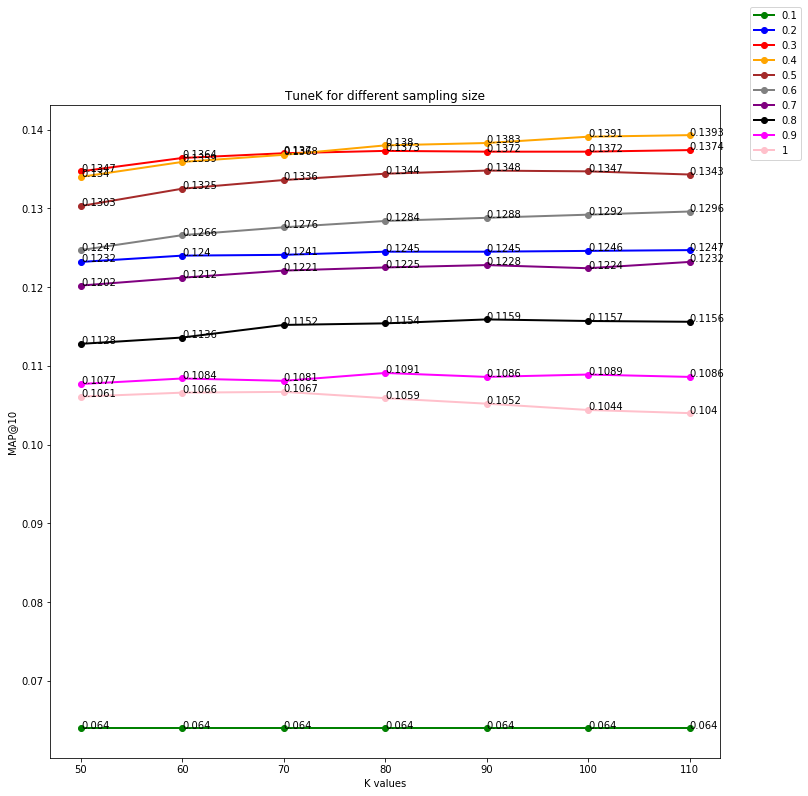

In [180]:
#Sort the list of MAP resutls for different training sampling and different k values
listsMAP10 = sorted(plotMAPList.items()) 

x1, y1 = zip(*plotMAPList[0.1].items()) # unpack a list of pairs into two tuples
x2, y2 = zip(*plotMAPList[0.2].items())
x3, y3 = zip(*plotMAPList[0.3].items())
x4, y4 = zip(*plotMAPList[0.4].items())
x5, y5 = zip(*plotMAPList[0.5].items()) 
x6, y6 = zip(*plotMAPList[0.6].items())
x7, y7 = zip(*plotMAPList[0.7].items())
x8, y8 = zip(*plotMAPList[0.8].items())
x9, y9 = zip(*plotMAPList[0.9].items())
x10, y10 = zip(*plotMAPList[1].items())

plt.figure(figsize=(12,12))
plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="0.1")
plt.plot( x2, y2, marker='o', color='blue', linewidth=2, label="0.2")
plt.plot( x3, y3, marker='o', color='red', linewidth=2, label="0.3")
plt.plot( x4, y4, marker='o', color='orange', linewidth=2, label="0.4")
plt.plot( x5, y5, marker='o',color='brown', linewidth=2, label="0.5")
plt.plot( x6, y6, marker='o', color='grey', linewidth=2, label="0.6")
plt.plot( x7, y7, marker='o', color='purple', linewidth=2, label="0.7")
plt.plot( x8, y8, marker='o', color='black', linewidth=2, label="0.8")
plt.plot( x9, y9, marker='o',color='magenta', linewidth=2, label="0.9")
plt.plot( x10, y10, marker='o', color='pink', linewidth=2, label="1")


for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
for x, y in zip(x2, y2): 
    plt.text(x, y, str(y))
for x, y in zip(x3, y3): 
    plt.text(x, y, str(y))
for x, y in zip(x4, y4): 
    plt.text(x, y, str(y))
for x, y in zip(x5, y5): 
    plt.text(x, y, str(y))
for x, y in zip(x6, y6): 
    plt.text(x, y, str(y))
for x, y in zip(x7, y7): 
    plt.text(x, y, str(y))
for x, y in zip(x8, y8): 
    plt.text(x, y, str(y))
for x, y in zip(x9, y9): 
    plt.text(x, y, str(y))
for x, y in zip(x10, y10): 
    plt.text(x, y, str(y))

    
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.title('TuneK for different sampling size')
plt.xlabel('K values')
plt.ylabel('MAP@10')

plt.show()

## Finding the best K

In [181]:
bestKForSampling = {}
for key in plotMAPList.keys():
    print(key, 'bestK:', max(plotMAPList[key].items(), key=operator.itemgetter(1))[0])
    bestKForSampling[key] = max(plotMAPList[key].items(), key=operator.itemgetter(1))[0]

0.1 bestK: 50
0.2 bestK: 110
0.3 bestK: 110
0.4 bestK: 110
0.5 bestK: 90
0.6 bestK: 110
0.7 bestK: 110
0.8 bestK: 90
0.9 bestK: 80
1.0 bestK: 70


## Compute performance for best K and plot

In [188]:
#Looping through different sampling size data and output performance using their best K
plotMAPListTest = {}
for sampleSize in bestKForSampling.keys():
    #Get rTrain and rTrain_Implicit now enjoying training and validation data sets
    rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False,
                                                                     remove_empty=False, threshold=3,
                                                                     sampling=False, sampling_ratio=0.1, 
                                                                     trainSampling=sampleSize)  
    
    rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True,
                                                                     remove_empty=False, threshold=3,sampling=False, 
                                                                     sampling_ratio=0.1, trainSampling=sampleSize)
    rtrain = rtrain + rvalid
    rtrain_implicit = rtrain_implicit + rvalid_implicit
    
    #Get the best K value for this sample size
    kValue = bestKForSampling[sampleSize]
    #TEST 
    rtest_binary = setBinary(rtest, 4)
    map10 = simpleKNNPrediction(rtrain_implicit, rtrain, kValue, rtest_binary)
    plotMAPListTest[sampleSize] = map10





  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  7%|█████▎                                                                       | 421/6085 [00:00<00:01, 4178.36it/s]



 14%|██████████▌                                                                  | 839/6085 [00:00<00:01, 4169.72it/s]



 21%|███████████████▌                                                            | 1250/6085 [00:00<00:01, 4142.46it/s]



 27%|████████████████████▋                                                       | 1660/6085 [00:00<00:01, 4120.45it/s]



 34%|█████████████████████████▊                                                  | 2070/6085 [00:00<00:00, 4105.36it/s]



 41%|███████████████████████████████                                             | 2486/6085 [00:00<00:00, 4112.58it/s]



 48%|████████████████████████████████████                                        | 2891/6085 [00:00<00:00, 4084.55it/s]



 54%|███████

  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 12%|█████████▍                                                                   | 750/6085 [00:00<00:00, 6857.08it/s]



 25%|██████████████████▋                                                         | 1496/6085 [00:00<00:00, 6847.09it/s]



 37%|████████████████████████████▏                                               | 2254/6085 [00:00<00:00, 6872.33it/s]



 50%|█████████████████████████████████████▋                                      | 3019/6085 [00:00<00:00, 6908.97it/s]



 62%|███████████████████████████████████████████████                             | 3773/6085 [00:00<00:00, 6904.32it/s]



 75%|████████████████████████████████████████████████████████▉                   | 4555/6085 [00:00<00:00, 6897.66it/s]



 86%|█████████████████████████████████████████████████████████████████           | 5206/6085 [00:00<00:00, 6769.74it/s]



 98%|███████████

 57%|███████████████████████████████████████████▊                                 | 3463/6085 [00:05<00:04, 595.22it/s]



 58%|████████████████████████████████████████████▌                                | 3524/6085 [00:05<00:04, 598.24it/s]



 59%|█████████████████████████████████████████████▎                               | 3585/6085 [00:05<00:04, 600.43it/s]



 60%|██████████████████████████████████████████████▏                              | 3646/6085 [00:05<00:04, 596.73it/s]



 61%|██████████████████████████████████████████████▉                              | 3707/6085 [00:06<00:03, 599.35it/s]



 62%|███████████████████████████████████████████████▋                             | 3768/6085 [00:06<00:03, 601.15it/s]



 63%|████████████████████████████████████████████████▍                            | 3829/6085 [00:06<00:03, 585.17it/s]



 64%|█████████████████████████████████████████████████▏                           | 3888/6085 [00:06<00:03, 585.34it/s]



 65%|███████████

 72%|███████████████████████████████████████████████████████                     | 4405/6085 [00:01<00:00, 4023.31it/s]



 79%|███████████████████████████████████████████████████████████▉                | 4801/6085 [00:01<00:00, 3924.19it/s]



 85%|████████████████████████████████████████████████████████████████▉           | 5197/6085 [00:01<00:00, 3926.31it/s]



 92%|█████████████████████████████████████████████████████████████████████▊      | 5587/6085 [00:01<00:00, 3909.78it/s]



 98%|██████████████████████████████████████████████████████████████████████████▊ | 5988/6085 [00:01<00:00, 3930.86it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 3943.96it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  9%|██████▊                                                                      | 535/6085 [00:00<00:01, 5311.22it/s]



 18%|███████████

 83%|██████████████████████████████████████████████████████████████▉             | 5037/6085 [00:01<00:00, 4569.12it/s]



 90%|████████████████████████████████████████████████████████████████████▌       | 5486/6085 [00:01<00:00, 4535.53it/s]



 98%|██████████████████████████████████████████████████████████████████████████  | 5934/6085 [00:01<00:00, 4468.02it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4506.25it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 11%|████████▊                                                                    | 697/6085 [00:00<00:00, 6917.53it/s]



 23%|█████████████████▎                                                          | 1388/6085 [00:00<00:00, 6900.13it/s]



 34%|██████████████████████████                                                  | 2086/6085 [00:00<00:00, 6908.83it/s]



 46%|███████████

 41%|███████████████████████████████▊                                             | 2514/6085 [00:04<00:05, 598.46it/s]



 42%|████████████████████████████████▌                                            | 2574/6085 [00:04<00:05, 597.66it/s]



 43%|█████████████████████████████████▎                                           | 2634/6085 [00:04<00:05, 583.17it/s]



 44%|██████████████████████████████████                                           | 2693/6085 [00:04<00:05, 583.93it/s]



 45%|██████████████████████████████████▊                                          | 2752/6085 [00:04<00:05, 579.26it/s]



 46%|███████████████████████████████████▌                                         | 2813/6085 [00:04<00:05, 585.23it/s]



 47%|████████████████████████████████████▎                                        | 2874/6085 [00:04<00:05, 589.49it/s]



 48%|█████████████████████████████████████▏                                       | 2935/6085 [00:04<00:05, 594.22it/s]



 49%|███████████

 88%|██████████████████████████████████████████████████████████████████▊         | 5352/6085 [00:00<00:00, 8850.23it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8842.48it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  7%|█████▍                                                                       | 427/6085 [00:00<00:01, 4237.83it/s]



 14%|██████████▍                                                                  | 829/6085 [00:00<00:01, 4160.60it/s]



 20%|███████████████▌                                                            | 1243/6085 [00:00<00:01, 4145.64it/s]



 27%|████████████████████▋                                                       | 1655/6085 [00:00<00:01, 4128.84it/s]



 34%|█████████████████████████▊                                                  | 2067/6085 [00:00<00:00, 4117.15it/s]



 41%|███████████

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4476.38it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 11%|████████▊                                                                    | 699/6085 [00:00<00:00, 6938.89it/s]



 22%|█████████████████                                                           | 1367/6085 [00:00<00:00, 6843.70it/s]



 34%|█████████████████████████▊                                                  | 2070/6085 [00:00<00:00, 6883.75it/s]



 45%|██████████████████████████████████▍                                         | 2759/6085 [00:00<00:00, 6870.64it/s]



 57%|███████████████████████████████████████████▏                                | 3455/6085 [00:00<00:00, 6882.26it/s]



 68%|███████████████████████████████████████████████████▊                        | 4150/6085 [00:00<00:00, 6887.61it/s]



 80%|███████████

 44%|█████████████████████████████████▌                                           | 2655/6085 [00:04<00:05, 581.14it/s]



 45%|██████████████████████████████████▎                                          | 2714/6085 [00:04<00:05, 579.07it/s]



 46%|███████████████████████████████████                                          | 2774/6085 [00:04<00:05, 583.96it/s]



 47%|███████████████████████████████████▊                                         | 2833/6085 [00:04<00:05, 582.75it/s]



 48%|████████████████████████████████████▌                                        | 2893/6085 [00:04<00:05, 586.57it/s]



 49%|█████████████████████████████████████▍                                       | 2954/6085 [00:05<00:05, 592.20it/s]



 50%|██████████████████████████████████████▏                                      | 3015/6085 [00:05<00:05, 575.89it/s]



 51%|██████████████████████████████████████▉                                      | 3075/6085 [00:05<00:05, 581.68it/s]



 52%|███████████

100%|███████████████████████████████████████████████████████████████████████████▉| 6081/6085 [00:00<00:00, 8654.89it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8605.51it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  7%|█████                                                                        | 404/6085 [00:00<00:01, 4009.58it/s]



 13%|██████████▏                                                                  | 807/6085 [00:00<00:01, 4006.94it/s]



 20%|███████████████▏                                                            | 1212/6085 [00:00<00:01, 4011.04it/s]



 27%|████████████████████▏                                                       | 1614/6085 [00:00<00:01, 4004.94it/s]



 33%|█████████████████████████▎                                                  | 2025/6085 [00:00<00:01, 4027.59it/s]



 39%|███████████

 99%|████████████████████████████████████████████████████████████████████████████▎| 6035/6085 [00:10<00:00, 599.78it/s]



100%|█████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:10<00:00, 590.44it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  7%|█████▍                                                                       | 434/6085 [00:00<00:01, 4308.56it/s]



 14%|██████████▊                                                                  | 859/6085 [00:00<00:01, 4281.36it/s]



 21%|████████████████▏                                                           | 1301/6085 [00:00<00:01, 4312.34it/s]



 29%|█████████████████████▊                                                      | 1747/6085 [00:00<00:00, 4346.38it/s]



 36%|███████████████████████████▍                                                | 2193/6085 [00:00<00:00, 4370.47it/s]



 43%|███████████

 32%|████████████████████████▍                                                    | 1927/6085 [00:02<00:05, 696.92it/s]



 33%|█████████████████████████▎                                                   | 1997/6085 [00:02<00:05, 692.20it/s]



 34%|██████████████████████████▏                                                  | 2069/6085 [00:02<00:05, 698.79it/s]



 35%|███████████████████████████                                                  | 2141/6085 [00:03<00:05, 703.55it/s]



 36%|████████████████████████████                                                 | 2213/6085 [00:03<00:05, 706.88it/s]



 38%|████████████████████████████▉                                                | 2286/6085 [00:03<00:05, 710.12it/s]



 39%|█████████████████████████████▊                                               | 2358/6085 [00:03<00:05, 703.20it/s]



 40%|██████████████████████████████▋                                              | 2429/6085 [00:03<00:05, 699.54it/s]



 41%|███████████

  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



  7%|█████▌                                                                       | 438/6085 [00:00<00:01, 3989.64it/s]



 15%|███████████▏                                                                 | 886/6085 [00:00<00:01, 3959.99it/s]



 21%|███████████████▉                                                            | 1274/6085 [00:00<00:01, 3917.41it/s]



 28%|█████████████████████▋                                                      | 1734/6085 [00:00<00:01, 3944.97it/s]



 35%|██████████████████████████▎                                                 | 2108/6085 [00:00<00:01, 3850.10it/s]



 42%|███████████████████████████████▉                                            | 2562/6085 [00:00<00:00, 3875.55it/s]



 49%|█████████████████████████████████████                                       | 2970/6085 [00:00<00:00, 3920.29it/s]



 56%|███████████

 90%|████████████████████████████████████████████████████████████████████        | 5450/6085 [00:00<00:00, 6550.98it/s]



100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 6826.24it/s]



  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]



 11%|████████▊                                                                    | 697/6085 [00:00<00:00, 6933.72it/s]



 23%|█████████████████▎                                                          | 1384/6085 [00:00<00:00, 6908.40it/s]



 36%|██████████████████████████▉                                                 | 2161/6085 [00:00<00:00, 6877.62it/s]



 46%|███████████████████████████████████▎                                        | 2829/6085 [00:00<00:00, 6811.74it/s]



 58%|███████████████████████████████████████████▉                                | 3522/6085 [00:00<00:00, 6820.98it/s]



 71%|███████████

 75%|█████████████████████████████████████████████████████████▋                   | 4562/6085 [00:05<00:01, 833.66it/s]



 76%|██████████████████████████████████████████████████████████▊                  | 4646/6085 [00:05<00:01, 831.25it/s]



 78%|███████████████████████████████████████████████████████████▊                 | 4730/6085 [00:05<00:01, 822.33it/s]



 79%|████████████████████████████████████████████████████████████▉                | 4813/6085 [00:05<00:01, 820.35it/s]



 80%|█████████████████████████████████████████████████████████████▉               | 4896/6085 [00:05<00:01, 814.21it/s]



 82%|██████████████████████████████████████████████████████████████▉              | 4978/6085 [00:05<00:01, 807.06it/s]



 83%|████████████████████████████████████████████████████████████████             | 5059/6085 [00:06<00:01, 806.18it/s]



 85%|█████████████████████████████████████████████████████████████████            | 5143/6085 [00:06<00:01, 814.30it/s]



 86%|███████████

## plot performance

In [189]:
plotMAPListTest

{0.1: 0.1388,
 0.2: 0.1405,
 0.3: 0.1336,
 0.4: 0.1269,
 0.5: 0.1187,
 0.6: 0.1133,
 0.7: 0.108,
 0.8: 0.1042,
 0.9: 0.1006,
 1.0: 0.1001}

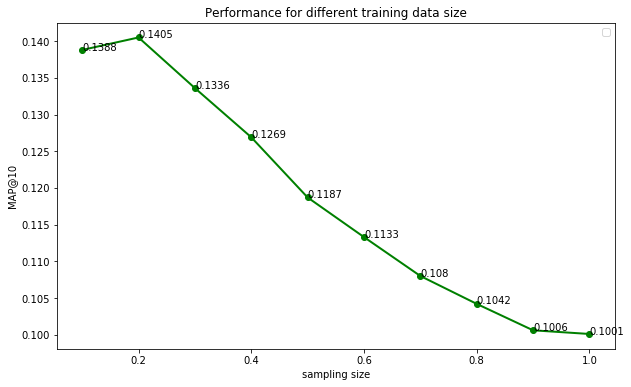

In [190]:
listPredictionTest = plotMAPListTest.items() # sorted by key, return a list of tuples


x1, y1 = zip(*listPredictionTest) # unpack a list of pairs into two tuples


plt.figure(figsize=(10,6))
plt.plot( x1, y1, marker='o',color='green', linewidth=2)


for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
      
plt.title('Performance for different training data size')
plt.legend()
plt.xlabel('sampling size')
plt.ylabel('MAP@10')
plt.show()

## User-rating KNN

### 1. With ratings that subtracts user average rating, cosine similarity
Tuning for different K 

In [ ]:
similarity1 = train(rtrain)
MAP10 = {}
for k in range(50, 120, 10):
    user_item_prediction_score1 = predict(rtrain_userAvg, k, similarity1, item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain_userAvg)
    user_item_res1 = evaluate(user_item_predict1, rvalid_userAvg)
    
    MAP10[k] = user_item_res1.get('MAP@10')[0]

In [ ]:
MAP10

## 5. With rating that subtracts businesses average rating, cosine similarity 

In [ ]:
similarity1 = train(rtrain)
MAP10ExpBusiness = {}
for k in range(50, 120, 10):
    user_item_prediction_score5 = predict(rtrain_userAvg, k, similarity1, item_similarity_en= False)
    user_item_predict5 = prediction(user_item_prediction_score5, 50, rtrain_userAvg)
    user_item_res5 = evaluate(user_item_predict5, rvalid_userAvg)
    
    MAP10ExpBusiness[k] = user_item_res5.get('MAP@10')[0]

In [ ]:
MAP10ExpBusiness

## 2. Implicit
Tuning for different K

In [ ]:
similarity1 = train(rtrain_implicit)
MAP10Implicit = {}
for k in range(50, 120, 10):
    user_item_prediction_score1 = predict(rtrain_implicit, k, similarity1, item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain_implicit)
    user_item_res1 = evaluate(user_item_predict1, rvalid_implicit)
    
    MAP10Implicit[k] = user_item_res1.get('MAP@10')[0]

## Implicit similarity + explicit prediction matrix
Tuning for different k

In [ ]:
similarity1 = train(rtrain_implicit)
MAP10Combine = {}
for k in range(40, 120, 10):
    user_item_prediction_score1 = predict(rtrain, k, similarity1, item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
    user_item_res1 = evaluate(user_item_predict1, rvalid)
    
    MAP10Combine[k] = user_item_res1.get('MAP@10')[0]

In [ ]:
MAP10Combine

## Plot for combined KNN, implicit similarity matrix, explicit user-rating matrix

In [ ]:
listsCombined = sorted(MAP10Combine.items()) # sorted by key, return a list of tuples

x1, y1 = zip(*listsCombined) # unpack a list of pairs into two tuples

plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="CombinedPrediction")
for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
    
plt.legend()
plt.xlabel('K values')
plt.ylabel('MAP@10')

plt.show()

### With ratings that subtracts user average rating, pearson correlation

In [30]:
# #UU similarity, using cosine similarity
# similarity2 = train(rtrain_userAvg)
# #get a user-item matrix  UI prediction
# #Predict using UI matrix with ratings in it 
# user_item_prediction_score2 = predict(rtrain_userAvg, 100, similarity2, item_similarity_en= False)
# user_item_predict2 = prediction(user_item_prediction_score2, 50, rtrain_userAvg)
# user_item_res2 = evaluate(user_item_predict2, rvalid_userAvg)
# user_item_res2

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4412.00it/s]


### 3. With raw ratings, cosinesimilarity
Tuning for different K

In [ ]:
similarity3 = train(rtrain)
MAP10ExplicitRaw = {}
for k in range(50, 120, 10):
    user_item_prediction_score3 = predict(rtrain, k, similarity3, item_similarity_en= False)
    user_item_predict3 = prediction(user_item_prediction_score3, 50, rtrain)
    user_item_res3 = evaluate(user_item_predict3, rvalid)
    
    MAP10ExplicitRaw[k] = user_item_res3.get('MAP@10')[0]

In [ ]:
MAP10ExplicitRaw.values()

## 4.User-visting matrix

In [ ]:
def getImplicitMatrix(sparseMatrix, threashold=0):
    temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
    temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
    return temp_matrix

userVisitMatrix = getImplicitMatrix(rtrain)

In [ ]:
MAP10UserVisit = {}
for k in range(50, 120, 10):
    similarity3 = train(userVisitMatrix)
    user_item_prediction_score3 = predict(userVisitMatrix, k, similarity3, item_similarity_en= False)
    user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
    user_item_res3 = evaluate(user_item_predict3, rvalid_implicit)
    
    MAP10UserVisit[k] = user_item_res3.get('MAP@10')[0]

In [ ]:
MAP10UserVisit.values()

## plot for best k 

In [ ]:
listsUserRatingScaled = sorted(MAP10.items()) # sorted by key, return a list of tuples
listsUserRatingImplicit = sorted(MAP10Implicit.items())
listsUserRatingExplicitRaw = sorted(MAP10ExplicitRaw.items())
listsUserRatingUserVisiting = sorted(MAP10UserVisit.items())

x1, y1 = zip(*listsUserRatingScaled) # unpack a list of pairs into two tuples
x2, y2 = zip(*listsUserRatingImplicit)
x3, y3 = zip(*listsUserRatingExplicitRaw)
x4, y4 = zip(*listsUserRatingUserVisiting)


plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="user_Rating_Scaled")
plt.plot( x2, y2, marker='o', color='blue', linewidth=2, label="user_Rating_Implicit")
plt.plot( x3, y3, marker='o', color='red', linewidth=2, label="user_Rating_Explicit")
plt.plot( x4, y4, marker='o', color='orange', linewidth=2, label="user_Visting")

for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
for x, y in zip(x2, y2): 
    plt.text(x, y, str(y))
for x, y in zip(x3, y3): 
    plt.text(x, y, str(y))
for x, y in zip(x4, y4): 
    plt.text(x, y, str(y))
    
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.title('Comparison between candidate matrcies')
plt.xlabel('K values')
plt.ylabel('MAP@10')

plt.show()

## Item Base KNN using TF-IDF

In [ ]:
IK_MATRIX = X_cleaned_sparse

In [ ]:
I_I_similarity = train(IK_MATRIX)
item_based_prediction_score4 = predict(rtrain, 10, I_I_similarity, item_similarity_en= True)
#for each restuarant top50 users 
item_based_predict4 = prediction(item_based_prediction_score4, 50, rtrain)

In [ ]:
item_based_res_TFIDF = evaluate(item_based_predict4, rvalid)

In [ ]:
item_based_res_TFIDF

## Try combining different similarity scores

In [ ]:
#UU similarity, using cosine similarity
similarity1 = train(rtrain)
similarity2 = train(rtrain_userAvg)
#similarity2 = None
similarity3 =train(userVisitMatrix)
#similarity3 = None
similarity4 = train(rtrain_implicit)
#similarity4 = None
#vectorU = predictUU(rtrain_userAvg, 90, similarity1, similarity2, similarity3, weight1, weight2, weight3, item_similarity_en= False)
user_item_prediction_score1 = predictUU(rtrain, 90, similarity1, similarity2, similarity3, similarity4, chooseWeigthMethod = [0,0,0,1], item_similarity_en= False)
user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
user_item_res1 = evaluate(user_item_predict1, rvalid)

## Iterations for different combination 

In [ ]:
#UU similarity, using cosine similarity
similarity1 = train(rtrain)
similarity2 = train(rtrain_userAvg)
#similarity2 = None
similarity3 =train(userVisitMatrix)
#similarity3 = None
similarity4 = train(rtrain_implicit)

predictionMatrixDict = {'prediction1':rtrain, 
                        'prediction2': rtrain_userAvg, 
                        'prediction3:': userVisitMatrix, 
                        'prediction4': rtrain_implicit}

SimilarityMatrixIndex = {1: [similarity1, None],
                         2: [similarity2, None],
                         3: [similarity3, None],
                         4: [similarity4, None]} 
combinationDict = {
    'comb1': [1, 2, 3, 4],
    'comb2': [1, 2, 3],
    'comb3': [1, 2, 4],
    'comb4': [2, 3, 4],
    'comb5': [1, 3, 4],
    'comb6': [1, 2],
    'comb7': [1, 3],
    'comb8': [1, 4],
    'comb9': [2, 3],
    'comb10': [2, 4],
    'combe11':[3,4]
    }

### Max
Prediction 1: rtrain; explicit raw rating

Prediction 2: explicit user rating, with user average

Prediction 3:user-visiting matrix

Prediction 4: Implicit user rating

In [ ]:
def computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit, combinationDict, SimilarityMatrixIndex, kTune, method='max'):

    prediction1 = {}
    prediction2 = {}
    prediction3 = {}
    prediction4 = {}

    for combination, indexList in combinationDict.items():
        #Loop through the similarity matrices 
        for index in SimilarityMatrixIndex.keys():
            if index in indexList:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][0]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][0]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][0]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][0]
            else:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][1]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][1]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][1]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][1]

        user_item_prediction_score1 = predictUU(rtrain, kTune, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod=method, item_similarity_en= False)
        user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
        user_item_res1 = evaluate(user_item_predict1, rvalid)
        prediction1[combination] = user_item_res1.get('MAP@10')[0]

        user_item_prediction_score2 = predictUU(rtrain_userAvg, kTune, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod=method, item_similarity_en= False)
        user_item_predict2 = prediction(user_item_prediction_score2, 50, rtrain_userAvg)
        user_item_res2 = evaluate(user_item_predict2, rvalid_userAvg)
        prediction2[combination] = user_item_res2.get('MAP@10')[0]

        user_item_prediction_score3 = predictUU(userVisitMatrix, kTune, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod=method, item_similarity_en= False)
        user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
        user_item_res3 = evaluate(user_item_predict3, rvalid_implicit)         
        prediction3[combination] = user_item_res3.get('MAP@10')[0]                

        user_item_prediction_score4 = predictUU(rtrain_implicit, kTune, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod=method, item_similarity_en= False)
        user_item_predict4 = prediction(user_item_prediction_score4, 50, rtrain_implicit)
        user_item_res4 = evaluate(user_item_predict4, rvalid_implicit)
        prediction4[combination] = user_item_res4.get('MAP@10')[0]
        
    plotingCombination(prediction1, prediction2, prediction3, prediction4, kTune, method)


In [ ]:
def plotingCombination(prediction1, prediction2, prediction3, prediction4, tuneK, method):
    listPrediction1 = prediction1.items() # sorted by key, return a list of tuples
    listPrediction2 = prediction2.items()
    listPrediction3 = prediction3.items()
    listPrediction4 = prediction4.items()

    x1, y1 = zip(*listPrediction1) # unpack a list of pairs into two tuples
    x2, y2 = zip(*listPrediction2)
    x3, y3 = zip(*listPrediction3)
    x4, y4 = zip(*listPrediction4)

    plt.figure(figsize=(10,6))
    
    "Please make sure that the label is correct"
    plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="ExplicitUserRating")
    plt.plot( x2, y2, marker='o',color='orange', linewidth=2, label="ScaledExplicitUserRating")
    plt.plot( x3, y3, marker='o',color='blue', linewidth=2, label="UserVisting")
    plt.plot( x4, y4, marker='o',color='red', linewidth=2, label="ImplicitUserRating")

    for x, y in zip(x1, y1): 
        plt.text(x, y, str(y))
    for x, y in zip(x2, y2): 
        plt.text(x, y, str(y))
    for x, y in zip(x3, y3): 
        plt.text(x, y, str(y))
    for x, y in zip(x4, y4): 
        plt.text(x, y, str(y))

#     plt.title(method, 'with k=', tuneK)
    plt.title('K for different methods', method, 'with k=', tuneK)
    plt.legend()
    plt.xlabel('Combinations')
    plt.ylabel('MAP@10')
    plt.show()

In [ ]:
# run this!!!!!!!!!!
for k in range (100, 120, 10):
    computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit, combinationDict, SimilarityMatrixIndex, k, method='max')

### Min

In [ ]:
predictionMin1 = {}
predictionMin2 = {}
predictionMin3 = {}
predictionMin4 = {}

for combination, indexList in combinationDict.items():
    #Loop through the similarity matrices 
    for index in SimilarityMatrixIndex.keys():
        if index in indexList:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][0]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][0]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][0]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
    
    #First matrix, explicit user rating matrx
    user_item_prediction_score1 = predictUU(rtrain, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='min', item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
    user_item_res1 = evaluate(user_item_predict1, rvalid)
    
    predictionMin1[combination] = user_item_res1.get('MAP@10')[0]
    
    #Second matrix, scaled explicit user raing matrix 
    user_item_prediction_score2 = predictUU(rtrain_userAvg, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='min', item_similarity_en= False)
    user_item_predict2 = prediction(user_item_prediction_score2, 50, rtrain_userAvg)
    user_item_res2 = evaluate(user_item_predict2, rvalid_userAvg)

    predictionMin2[combination] = user_item_res2.get('MAP@10')[0]
    
    #Third matrix, implicit user-visitng matrix 
    user_item_prediction_score3 = predictUU(userVisitMatrix, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='min', item_similarity_en= False)
    user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
    user_item_res3 = evaluate(user_item_predict3, rvalid_implicit)
            
    predictionMin3[combination] = user_item_res3.get('MAP@10')[0]
    
    #Fourth matrix, Implicit user-rating matrix 
    user_item_prediction_score4 = predictUU(rtrain_implicit, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='min', item_similarity_en= False)
    user_item_predict4 = prediction(user_item_prediction_score4, 50, rtrain_implicit)
    user_item_res4 = evaluate(user_item_predict4, rvalid_implicit)

    predictionMin4[combination] = user_item_res4.get('MAP@10')[0]
    
            

    

In [ ]:
listPredictionMin1 = predictionMin1.items() # sorted by key, return a list of tuples
listPredictionMin2 = predictionMin2.items()
listPredictionMin3 = predictionMin3.items()
listPredictionMin4 = predictionMin4.items()

x1, y1 = zip(*listPredictionMin1) # unpack a list of pairs into two tuples
x2, y2 = zip(*listPredictionMin2)
x3, y3 = zip(*listPredictionMin3)
x4, y4 = zip(*listPredictionMin4)

plt.figure(figsize=(10,7))
plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="ExplicitUserRating")
plt.plot( x2, y2, marker='o',color='orange', linewidth=2, label="ScaledExplicitUserRating")
plt.plot( x3, y3, marker='o',color='blue', linewidth=2, label="UserVisting")
plt.plot( x4, y4, marker='o',color='red', linewidth=2, label="ImplicitUserRating")

for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
for x, y in zip(x2, y2): 
    plt.text(x, y, str(y))
for x, y in zip(x3, y3): 
    plt.text(x, y, str(y))
for x, y in zip(x4, y4): 
    plt.text(x, y, str(y))
      
plt.title('Min (k=90)')
plt.legend()
plt.xlabel('Combinations')
plt.ylabel('MAP@10')
plt.show()

### Average

In [ ]:
predictionAvg1 = {}
predictionAvg2 = {}
predictionAvg3 = {}
predictionAvg4 = {}

for combination, indexList in combinationDict.items():
    #Loop through the similarity matrices 
    for index in SimilarityMatrixIndex.keys():
        if index in indexList:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][0]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][0]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][0]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
    
    #First matrix, explicit user rating matrx
    user_item_prediction_score1 = predictUU(rtrain, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='average', item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
    user_item_res1 = evaluate(user_item_predict1, rvalid)
    
    predictionAvg1[combination] = user_item_res1.get('MAP@10')[0]
    
    #Second matrix, scaled explicit user raing matrix 
    user_item_prediction_score2 = predictUU(rtrain_userAvg, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='average', item_similarity_en= False)
    user_item_predict2 = prediction(user_item_prediction_score2, 50, rtrain_userAvg)
    user_item_res2 = evaluate(user_item_predict2, rvalid_userAvg)

    predictionAvg2[combination] = user_item_res2.get('MAP@10')[0]
    
    #Third matrix, implicit user-visitng matrix 
    user_item_prediction_score3 = predictUU(userVisitMatrix, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='average', item_similarity_en= False)
    user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
    user_item_res3 = evaluate(user_item_predict3, rvalid_implicit)
            
    predictionAvg3[combination] = user_item_res3.get('MAP@10')[0]
    
    #Fourth matrix, Implicit user-rating matrix 
    user_item_prediction_score4 = predictUU(rtrain_implicit, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='average', item_similarity_en= False)
    user_item_predict4 = prediction(user_item_prediction_score4, 50, rtrain_implicit)
    user_item_res4 = evaluate(user_item_predict4, rvalid_implicit)

    predictionAvg4[combination] = user_item_res4.get('MAP@10')[0] 

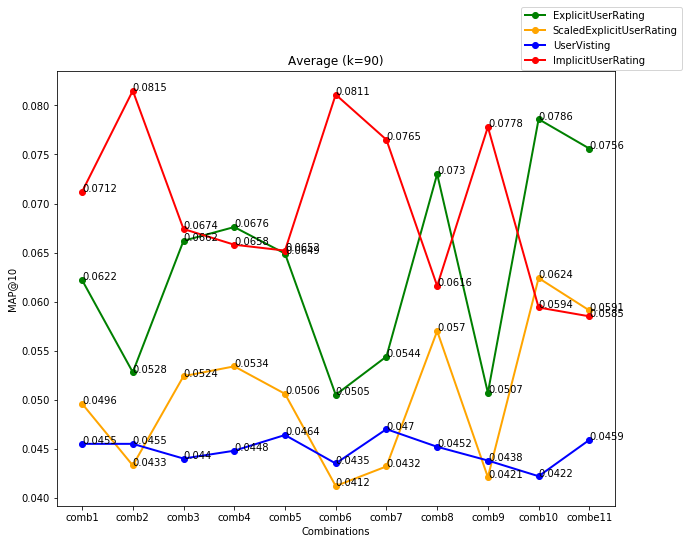

In [38]:
listPredictionAvg1 = predictionAvg1.items() # sorted by key, return a list of tuples
listPredictionAvg2 = predictionAvg2.items()
listPredictionAvg3 = predictionAvg3.items()
listPredictionAvg4 = predictionAvg4.items()

x1, y1 = zip(*listPredictionAvg1) # unpack a list of pairs into two tuples
x2, y2 = zip(*listPredictionAvg2)
x3, y3 = zip(*listPredictionAvg3)
x4, y4 = zip(*listPredictionAvg4)

plt.figure(figsize=(10,8))
plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="ExplicitUserRating")
plt.plot( x2, y2, marker='o',color='orange', linewidth=2, label="ScaledExplicitUserRating")
plt.plot( x3, y3, marker='o',color='blue', linewidth=2, label="UserVisting")
plt.plot( x4, y4, marker='o',color='red', linewidth=2, label="ImplicitUserRating")

for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
for x, y in zip(x2, y2): 
    plt.text(x, y, str(y))
for x, y in zip(x3, y3): 
    plt.text(x, y, str(y))
for x, y in zip(x4, y4): 
    plt.text(x, y, str(y))
      
plt.title('Average (k=90)')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.xlabel('Combinations')
plt.ylabel('MAP@10')
plt.show()

In [ ]:
# def getImplicitMatrix(sparseMatrix, threashold=0):
#     temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
#     temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
#     return temp_matrix

# userVisitMatrix = getImplicitMatrix(rtrain)

In [ ]:
#UU similarity
similarity3 = train(userVisitMatrix)
#get a user-item matrix  UI prediction
#Predict using UI matrix with ratings in it 
user_item_prediction_score3 = predict(userVisitMatrix, 90, similarity3, item_similarity_en= False)
user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
#Check user item prediction score
user_item_res3 = evaluate(user_item_predict3, rvalid)

In [ ]:
user_item_res3

In [ ]:
rtrain[0].toarray()

In [ ]:
for user_index in tqdm(range(2)):
    print(user_index)

In [ ]:
userVisitMatrix.shape

In [ ]:
rtrain.shape

In [ ]:
max(5,8,9,10)

In [ ]:
stats.mean([1,1,1,1])

In [185]:
max([5,10,2], [10,5,9], [2,5,13])

[10, 5, 9]

In [69]:
a = np.array([[10, 2, 100], [3, 4, 50], [5, 6,40]])

In [70]:
a

array([[ 10,   2, 100],
       [  3,   4,  50],
       [  5,   6,  40]])

In [83]:
a.mean(axis=0)

array([ 6.        ,  4.        , 63.33333333])

In [98]:
flag = isinstance(["10","50","20"], list)
print(flag)

True


In [95]:
type([10,50,20])

list

In [99]:
a

array([[ 10,   2, 100],
       [  3,   4,  50],
       [  5,   6,  40]])

In [100]:
b = [3,4,2]

In [103]:
type(b)

list

In [106]:
(a * b).sum(axis=0)

array([ 54,  48, 380])

In [107]:
a * b

array([[ 30,   8, 200],
       [  9,  16, 100],
       [ 15,  24,  80]])

(3, 1)